In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
import time
import sys
import os
from multiprocessing import Pool
from functools import partial
directory = 'figures'
if not os.path.exists(directory):
    os.makedirs(directory)
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm.notebook import tqdm
import numpy as np
from dask.distributed import Client, progress, LocalCluster
from dask import compute, delayed
import dask.array as da
from dask.diagnostics import ProgressBar
plt.rcParams['figure.dpi']=400

In [3]:
def denseH_MBL(L, J, hx_list, hz_list, periodic):
    """
    Generates the dense Hamiltonian matrix for the quantum Ising chain with both transverse and longitudinal magnetic fields
    
        Parameters:
            L (int): length of chain
            J (float): ising interaction strength
            hx (ndarray): array of transverse field strengths
            hz (ndarray): array of longitudinal field strengths
            periodic (bool): does the chain have periodic boundary conditions?
            
        Returns:
            H (ndarray): 2^L x 2^L matrix representing the Hamiltonian operator
    """

    dim=2 ** L # dimensions of the Hilbert space
    
    H = np.zeros((dim, dim), dtype = float) # initliaze the Hamiltonian
    
    "Calculation of off-diagonal elements due to the magnetic field"
    
    for beta in range(dim): # iterate over all states
        
        for j in range(1,L+1): # iterate over all sites
            
            alpha = beta ^ (1<<j-1) # flips jth bit of beta to get the state alpha that is related to beta by a single bit flip
            
            H[alpha, beta] -= hx_list[j-1] # contribution by sigma^j_x
            
            
            
    "Calculation of diagonal elements due to Ising interaction"

    for alpha in range(dim): # iterate over all states
        
        for j in range(1, L): # iterate over all sites
            
            if 2*(alpha & (1 << j-1)) == alpha & (1 << j): # check if site j and j+1 have the same spin
                
                H[alpha, alpha] -= J # if they do, decrease the energy by the ising interaction term
                
            else:
                
                H[alpha, alpha] += J # if not, increase the energy by the ising interaction term
            
        "Diagonal elements due to longitudinal magnetic field"
        
        for j in range(1, L+1):
            
            if alpha & (1 << (j-1)) == 0:  # check if the spin at site j is up
                H[alpha, alpha] -= hz_list[j-1]  # decrease energy for spin up
                
            else:
                H[alpha, alpha] += hz_list[j-1]  # increase energy for spin down

        
        "Handling case of periodic boundary conditions"
                
        if periodic and L > 1: # L > 1 needed for periodicity to mean anything
            
            if (alpha & (1 << L-1)) == ((alpha & (1 << 0))*(2**(L-1))): # Check if the states at either end have the same spin
                
                H[alpha, alpha] -= J # if they do, decrease the energy by the ising interaction term
                
            else:
                
                H[alpha, alpha] += J # if not, increase the energy by the ising interaction term
                
    return H   



def diagonalize_MBL(Ls, J, hx_list, hz_list, periodic):
    eigss = []
    vecss = []
    
    for i, L in enumerate(Ls):
        hx = hx_list[i]
        hz = hz_list[i]
        H = denseH_MBL(L, J, hx, hz, periodic)
        eigs, vecs = scipy.linalg.eigh(H)
        eigss.append(eigs)
        vecss.append(vecs)
    
    return eigss, vecss


In [10]:
eps = np.array([[1/2],[-np.sqrt(3)/2]])

def psi_initial(L):

    psi_0 = eps
    for _ in range(1, L):
        psi_0 = np.kron(psi_0, eps)
    
    return psi_0

In [22]:
def generate_disorder(L, W, J, periodic):
    """ Generate disorder until a valid realization is found. """
    psi_0 = psi_initial(L)
    while True:
        hx = np.random.uniform(-W, W, L)
        hz = np.random.uniform(-W, W, L)
        H = denseH_MBL(L, J, hx, hz, periodic)
        target_energy = np.real(np.conj(psi_0).T @ H @ psi_0)
        if target_energy < 0:
            return hx, hz

In [38]:
Ls = [6, 8, 10, 12]
J = 1
W = 3
periodic = True
num_realizations = 10


all_eigss = [[] for _ in Ls]
all_vecss = [[] for _ in Ls]
disorders = [[] for _ in Ls]
for i, L in enumerate(Ls):
    with tqdm(total=num_realizations, desc=f"Processing L={L}") as pbar:
        for _ in range(num_realizations):
            disorder = generate_disorder(L, W, J, periodic)
            disorders[i].append(disorder)
            hx_list, hz_list = disorder
            H = denseH_MBL(L, J, hx_list, hz_list, periodic)
            eigs, vecs = scipy.linalg.eigh(H)
            
            all_eigss[i].append(eigs)
            all_vecss[i].append(vecs)

            pbar.update(1)

Processing L=6:   0%|          | 0/10 [00:00<?, ?it/s]

Processing L=8:   0%|          | 0/10 [00:00<?, ?it/s]

Processing L=10:   0%|          | 0/10 [00:00<?, ?it/s]

Processing L=12:   0%|          | 0/10 [00:00<?, ?it/s]

### Matrix elements of the spin operators

In [11]:
def sigma(mu, vecs):
    
    N = len(vecs)
    
    sigma_vecs = np.zeros((len(vecs[0]), N), dtype = complex)
    
    for i in range(N):
        
        vec = vecs[:, i]

        for alpha in range(len(vec)):
        
            if mu == 'z':
                if alpha & 1 :
                    sigma_vecs[alpha, i] -= vec[alpha]
                else:
                    sigma_vecs[alpha, i] = vec[alpha]
                    
            elif mu == 'y':
                beta = alpha ^ 1 
                
                if alpha & 1:
                    sigma_vecs[beta, i] = -1j * vec[alpha]
                else:
                    sigma_vecs[beta, i] = 1j * vec[alpha]

            elif mu == 'x':
                beta = alpha ^ (1 << 0)
                sigma_vecs[beta, i] = vec[alpha]
    
    return np.conj(vecs).T @ sigma_vecs


### Expectation value of the spin operators

In [12]:
def expectation_value(sigma_matrix, eigs, coeffs, t):

    delta_eigs = eigs[:, np.newaxis] - eigs[np.newaxis, :]
    
    phase_factors = np.exp(-1j * delta_eigs * t)
    
    coeff_matrix = np.outer(np.conj(coeffs), coeffs)
    
    total_matrix = coeff_matrix * phase_factors * sigma_matrix
    
    return np.real(np.sum(total_matrix))

## Thermal average

Processing L=6:   0%|          | 0/10 [00:00<?, ?it/s]

Processing L=8:   0%|          | 0/10 [00:00<?, ?it/s]

Processing L=10:   0%|          | 0/10 [00:00<?, ?it/s]

Processing L=12:   0%|          | 0/10 [00:00<?, ?it/s]

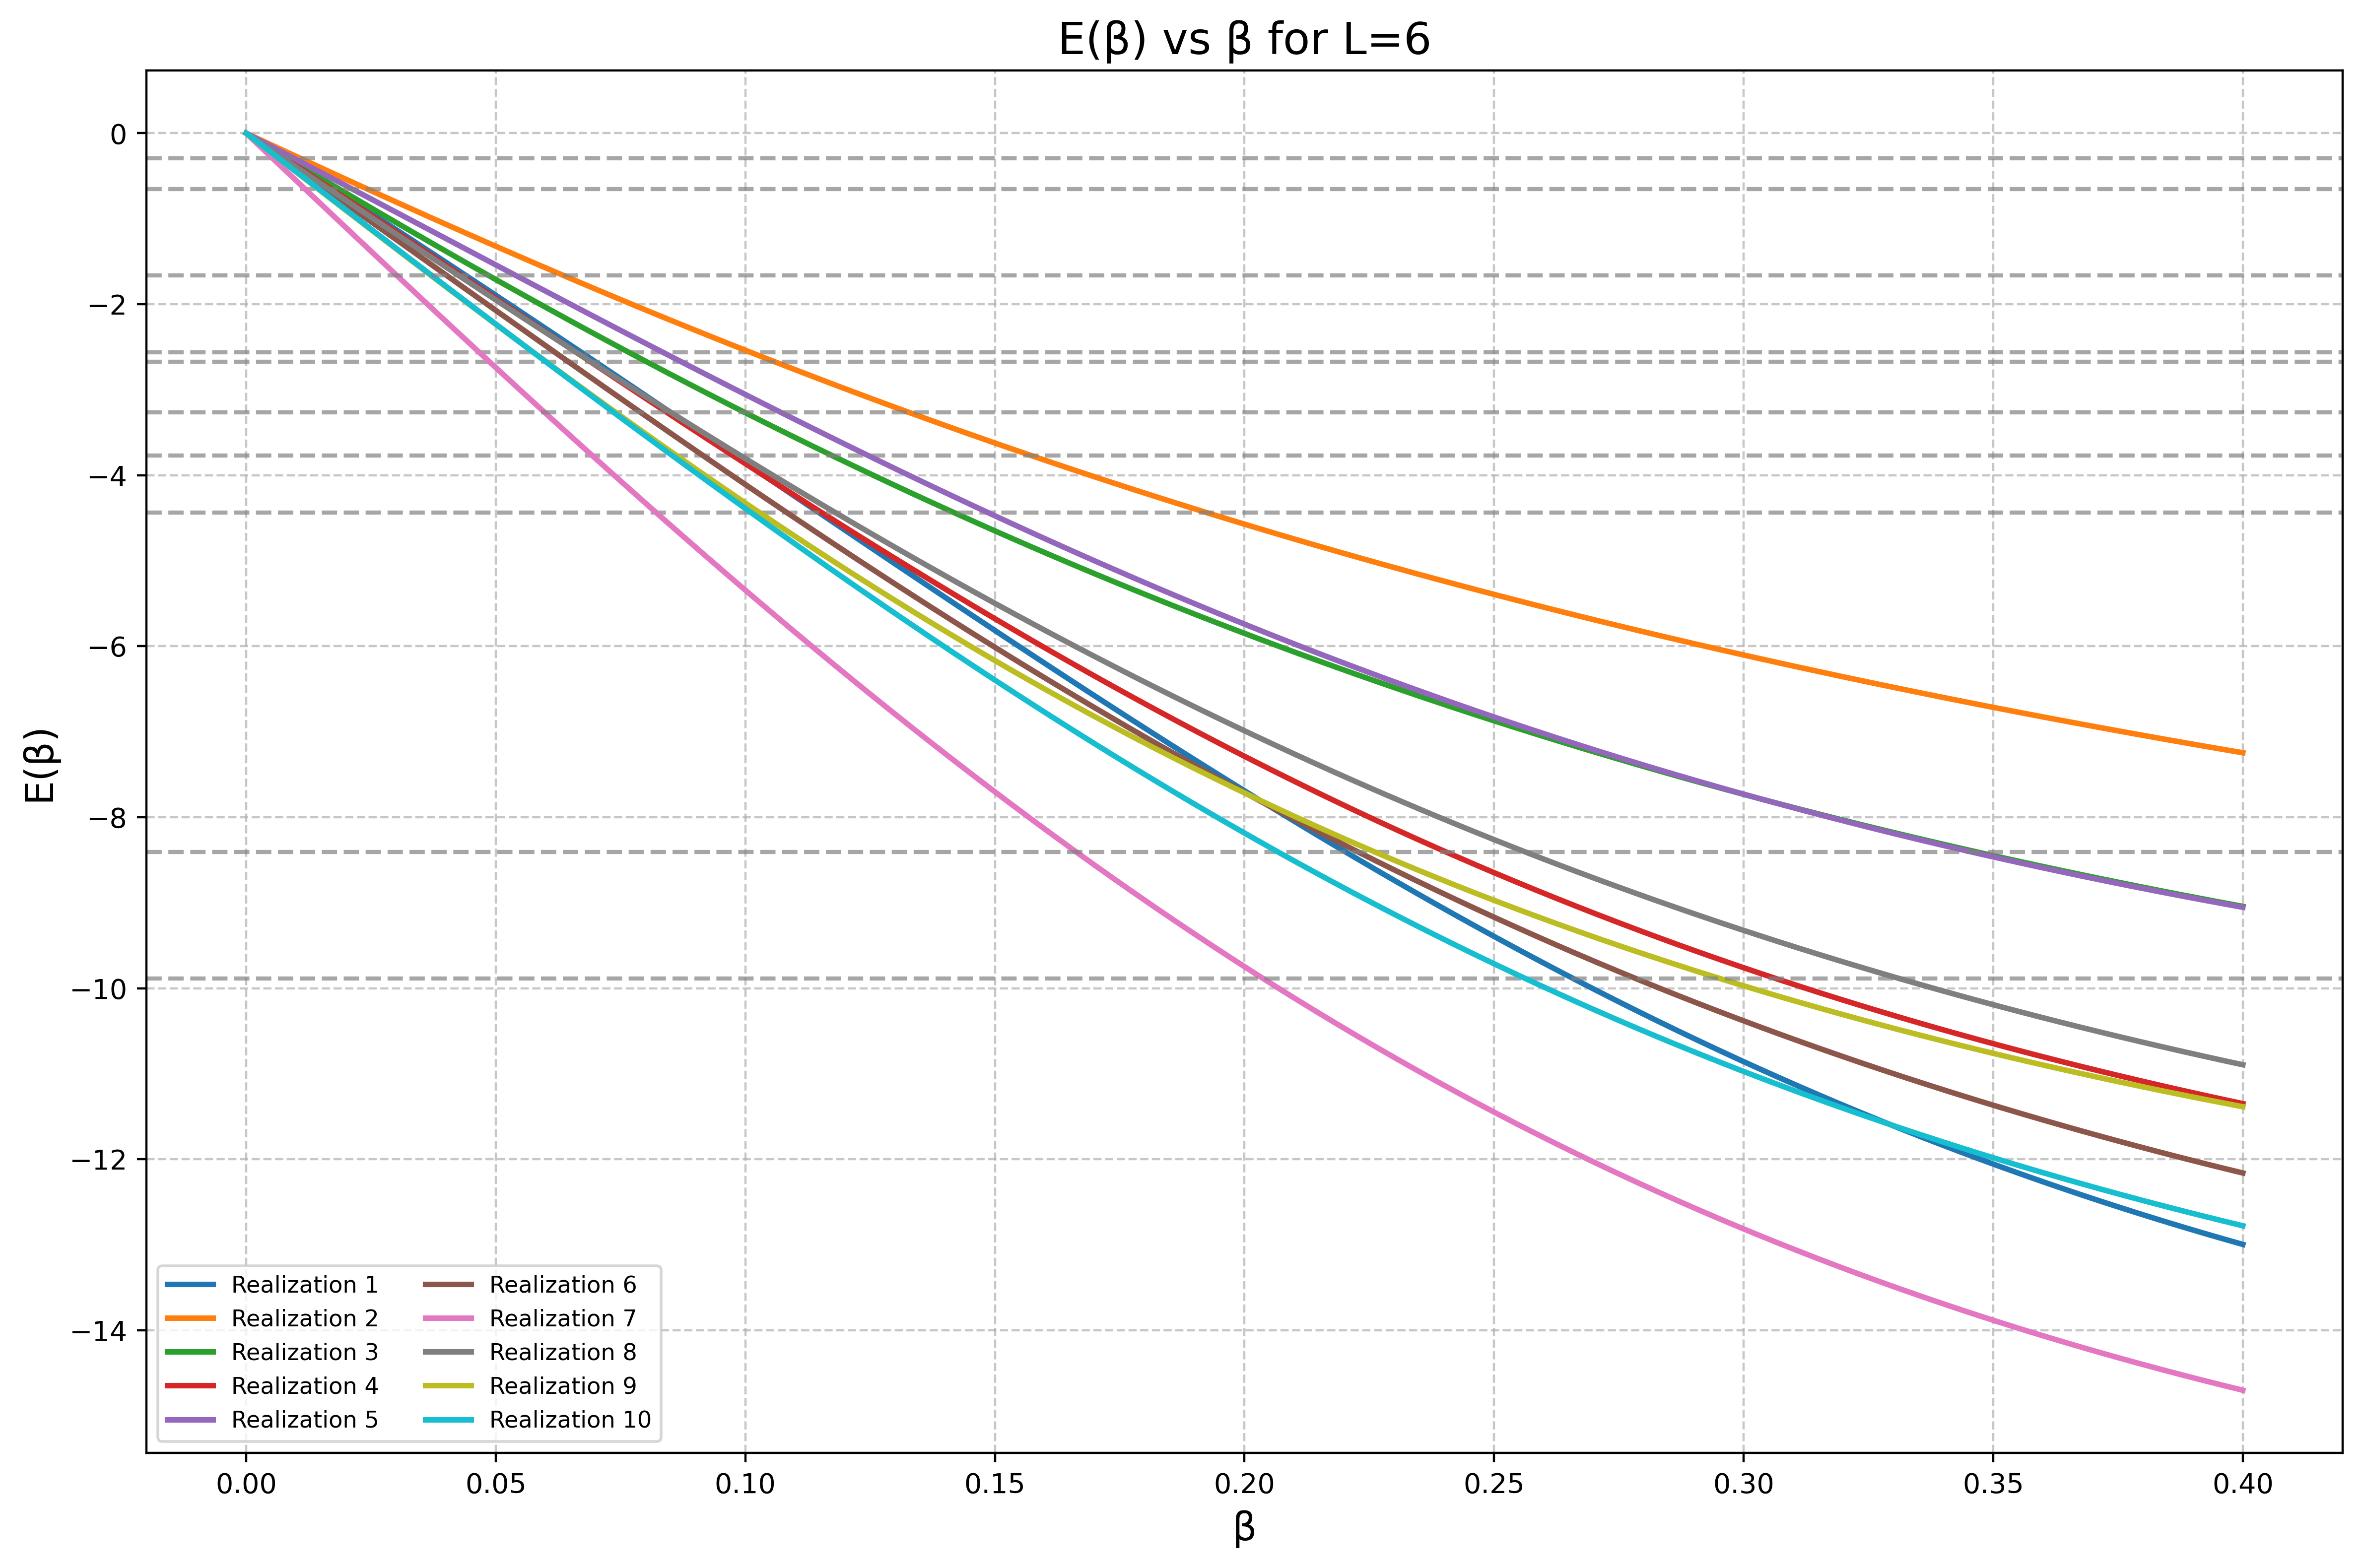

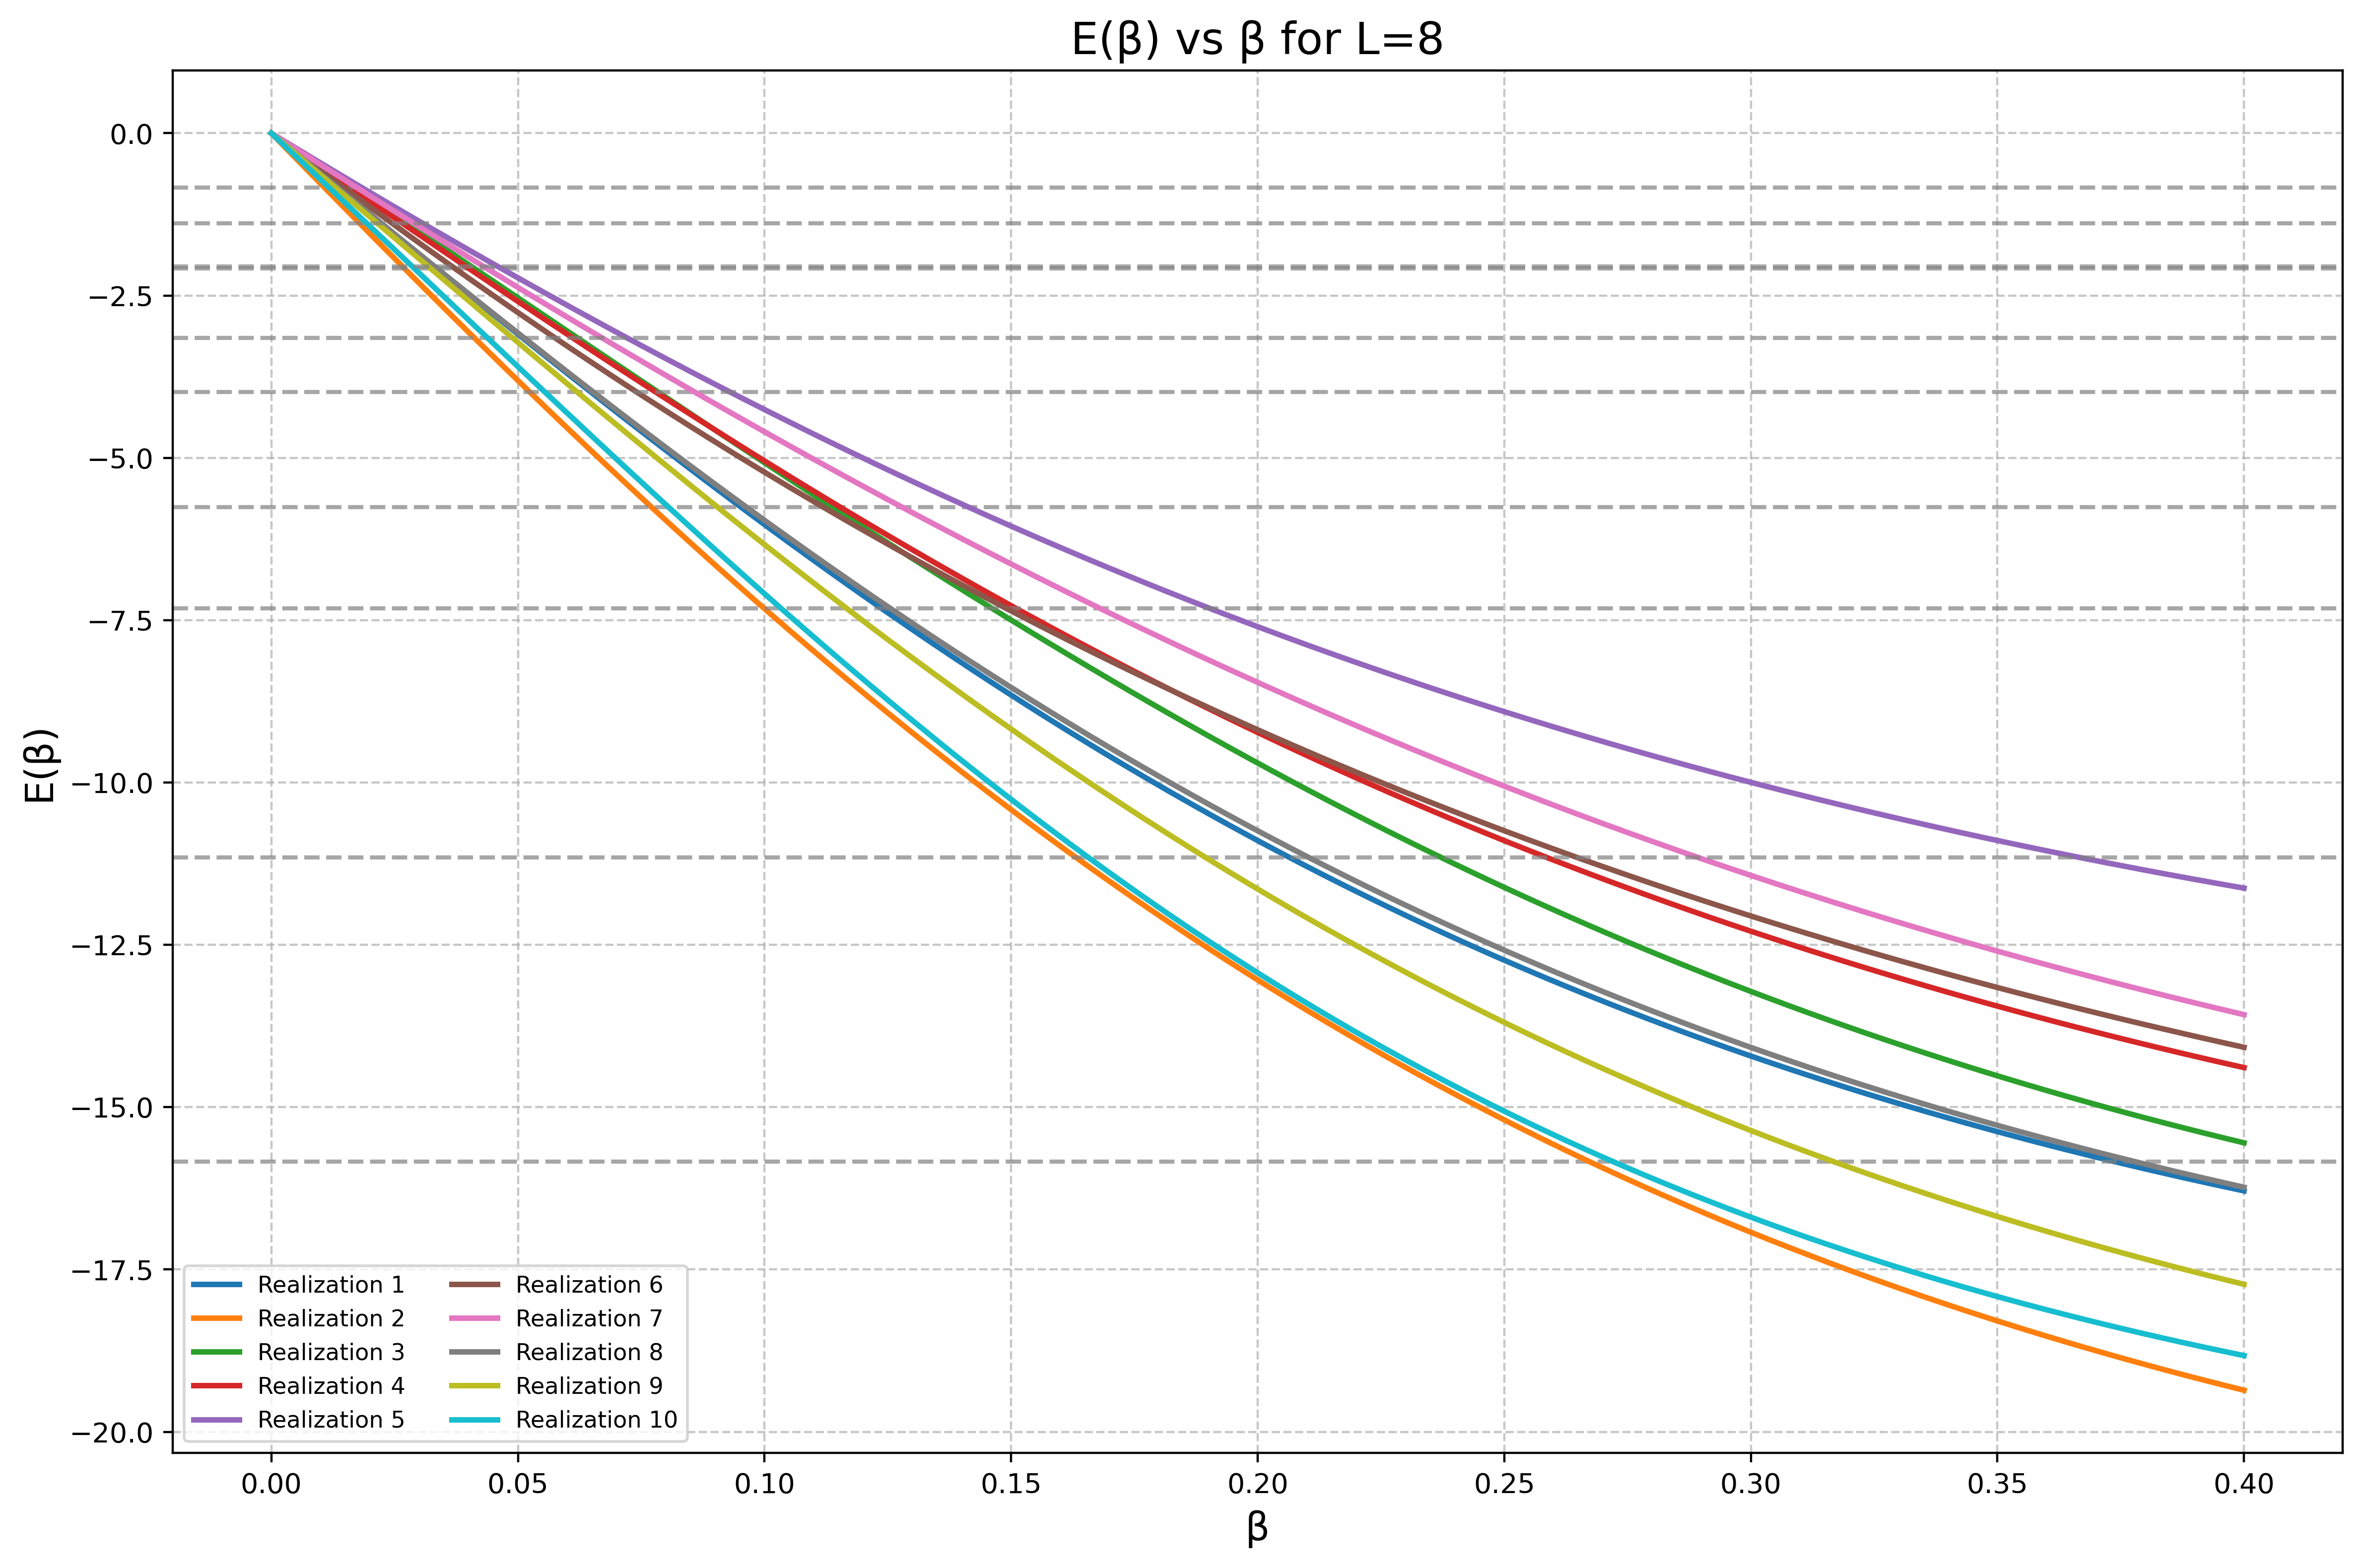

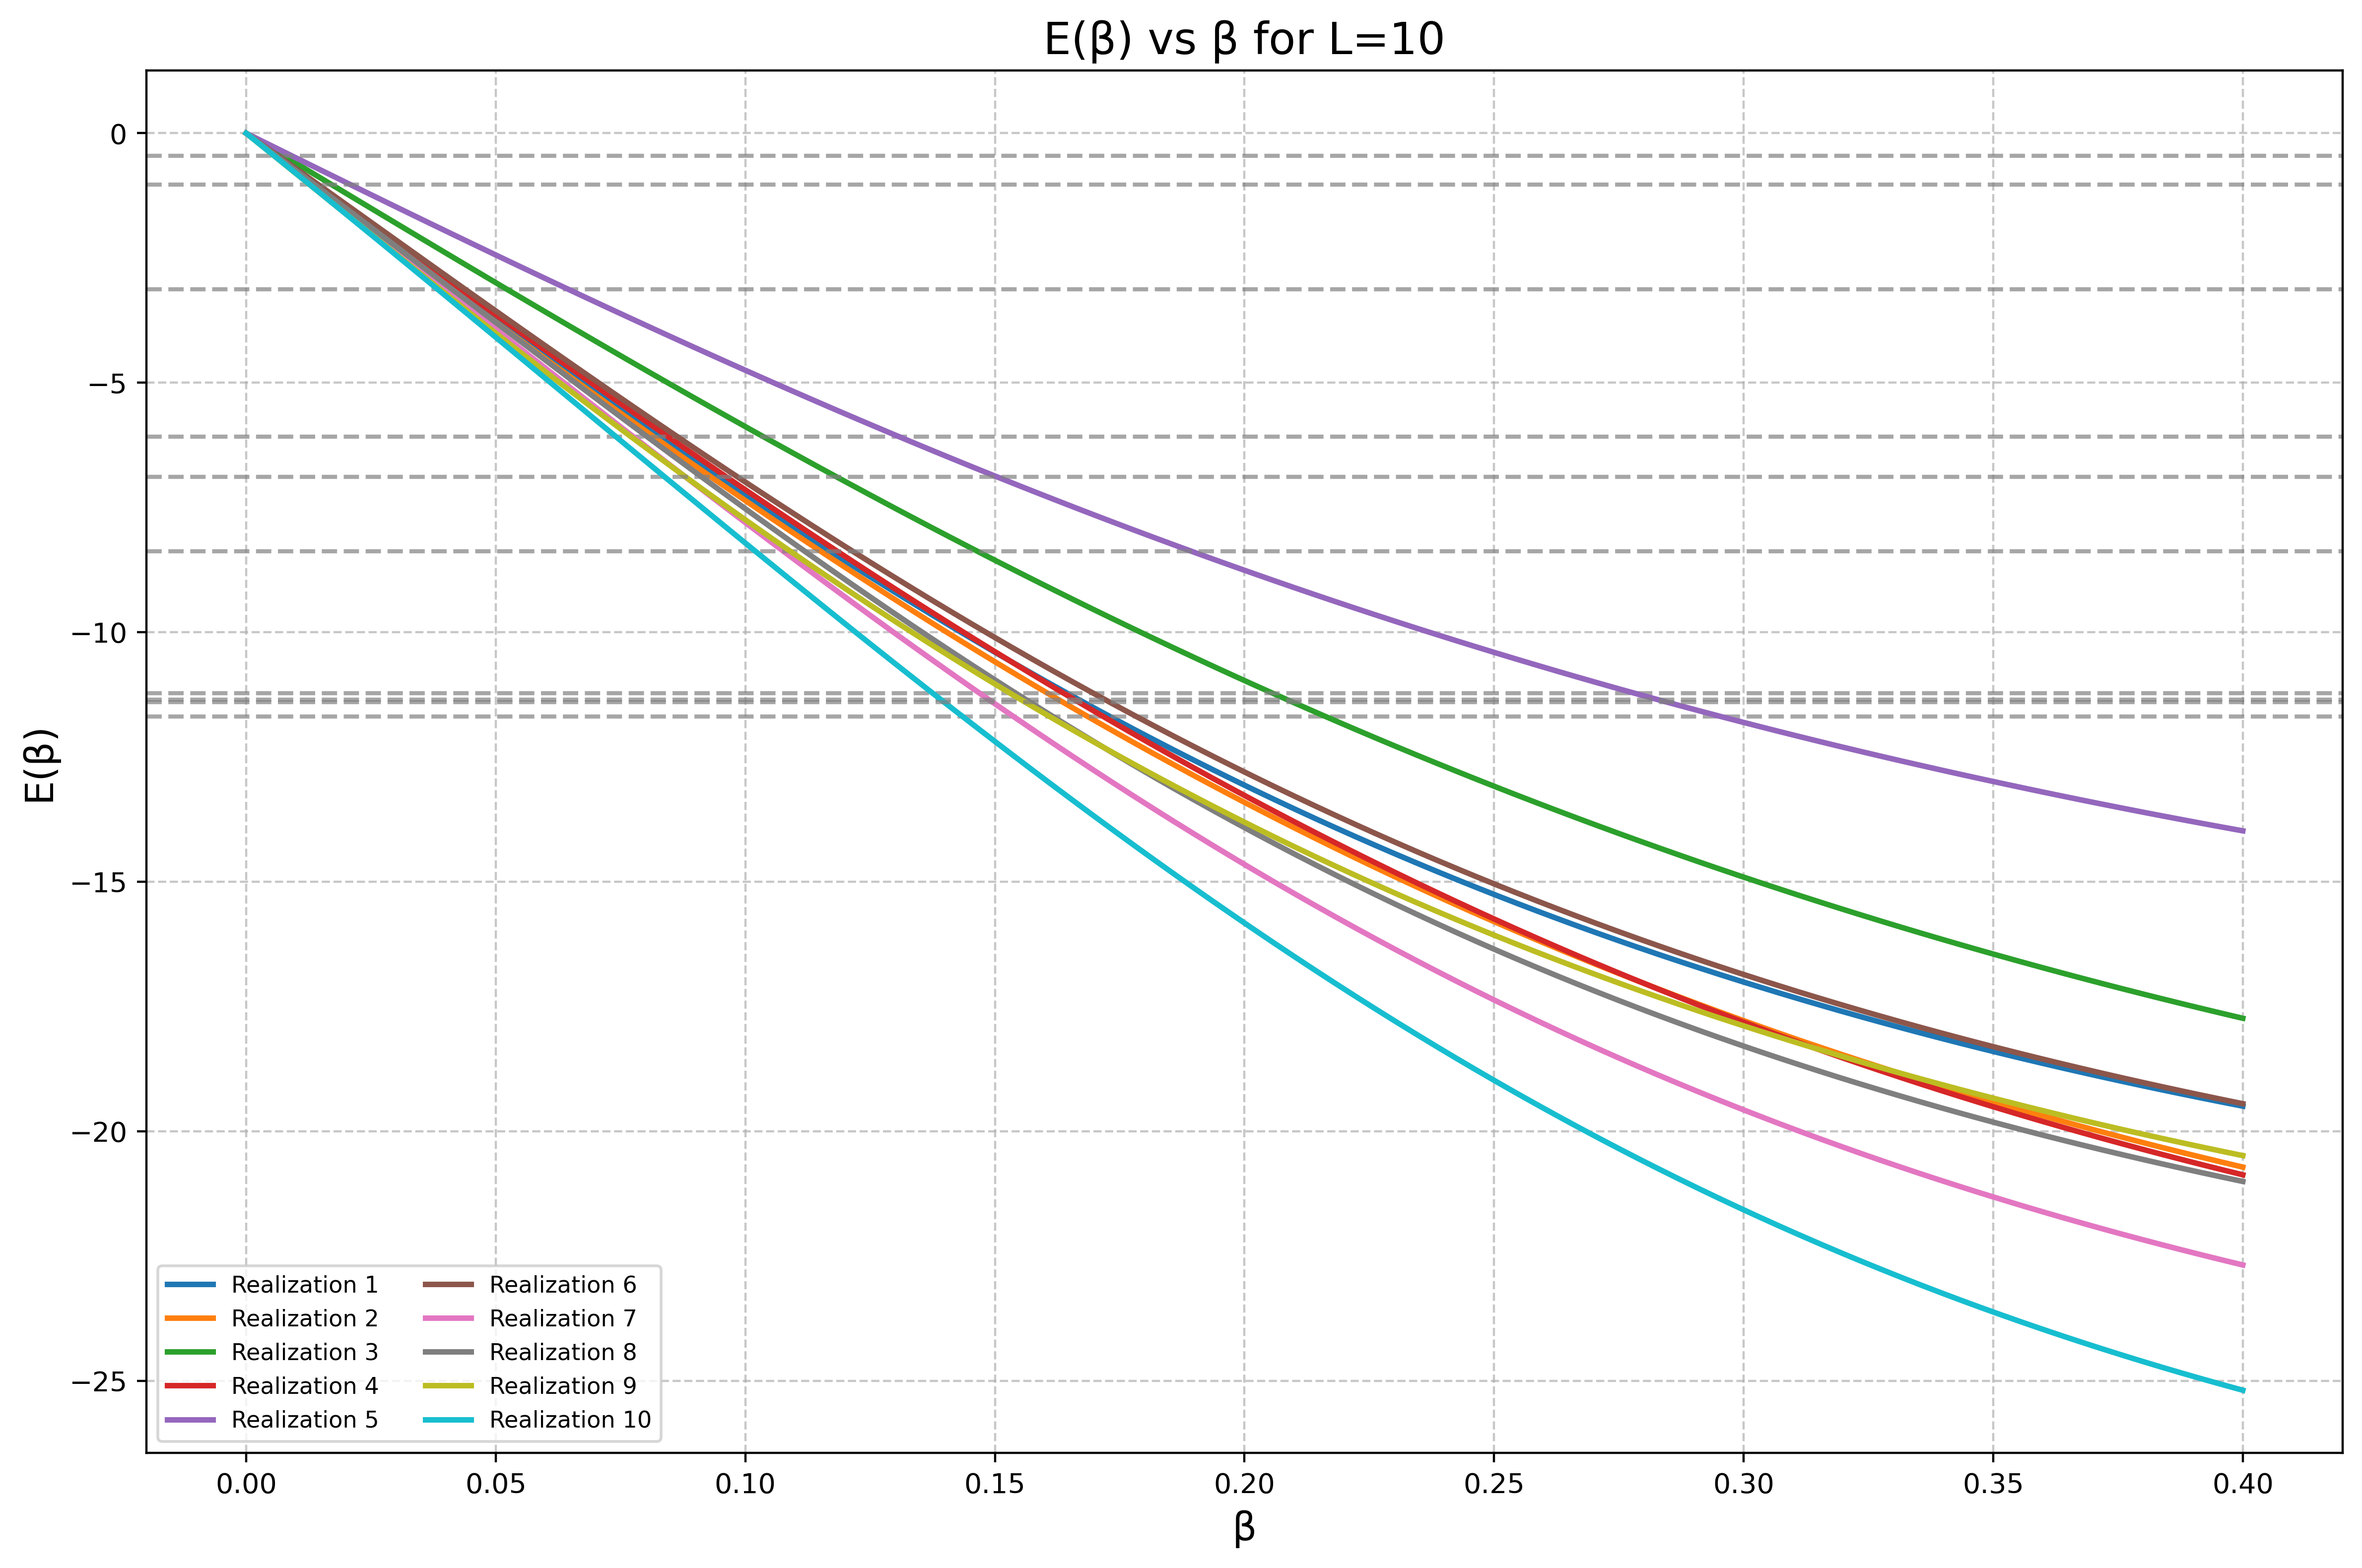

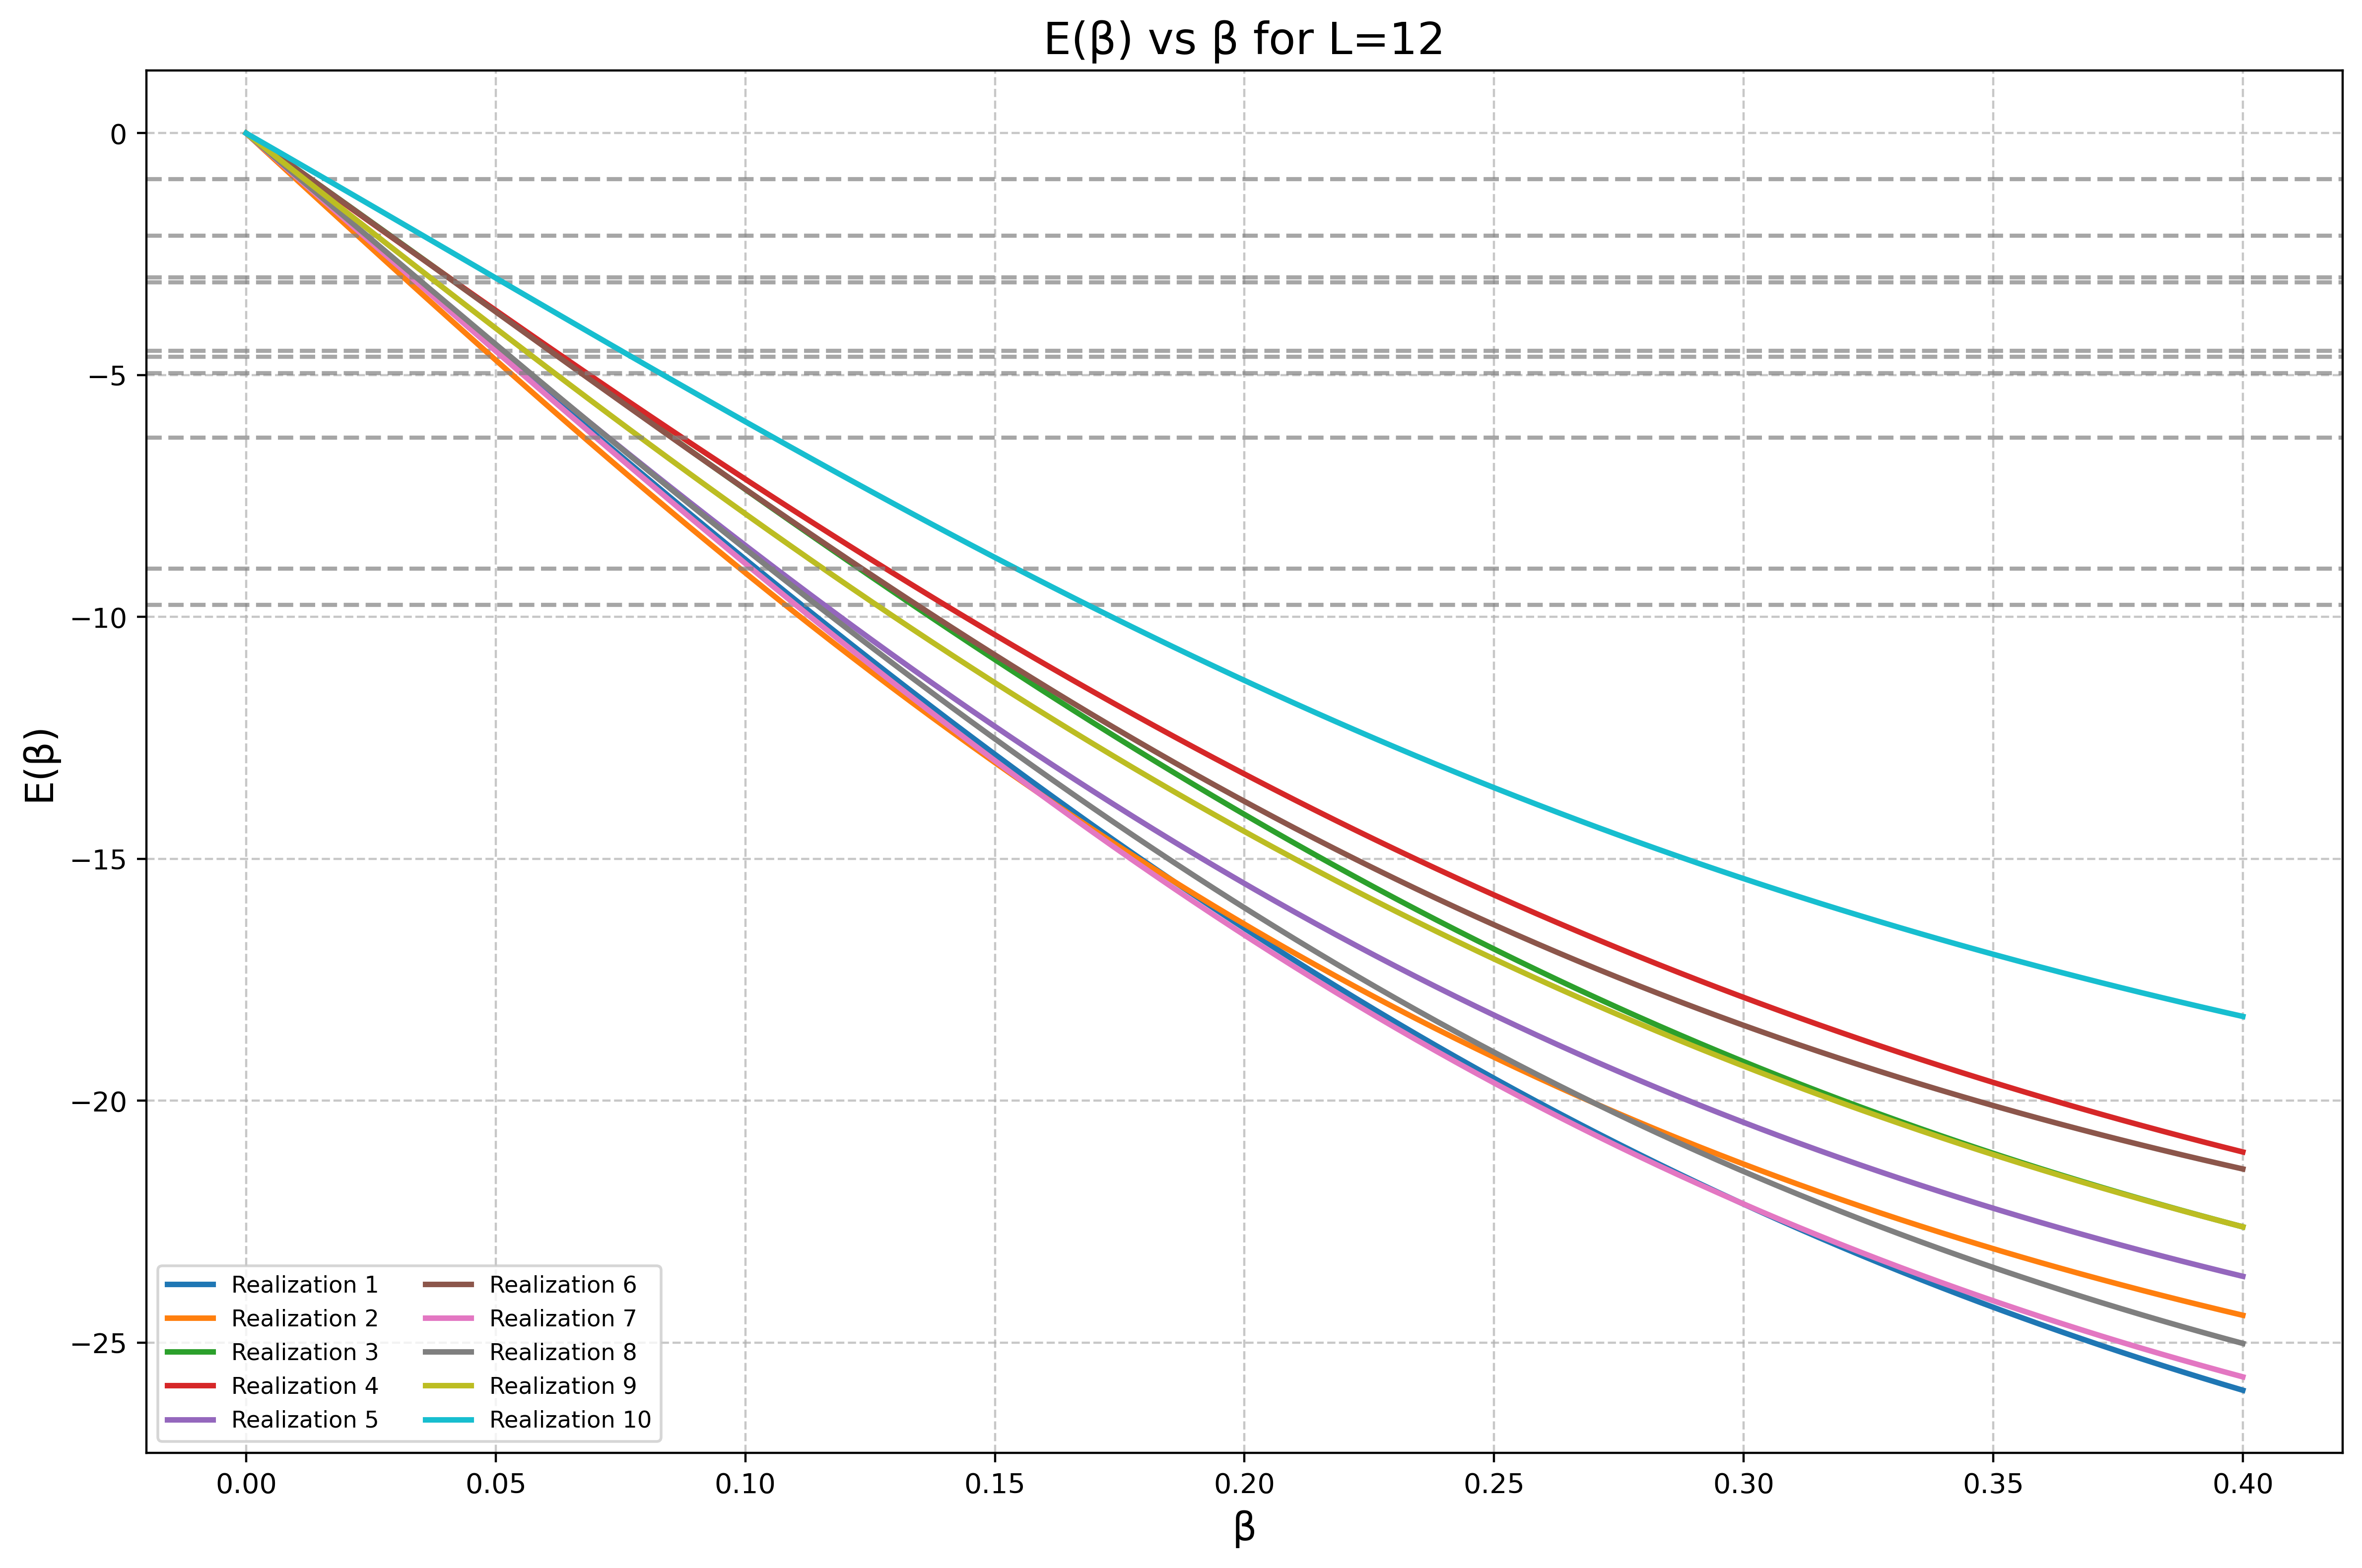

In [39]:
def thermal_state_energy(beta, eigs):
    
    Z = np.sum(np.exp(-beta*eigs))
    
    P = np.sum(np.exp(-beta*eigs)*eigs)
    
    return P/Z


def find_best_beta(eigs, target_energy, betas):

    min_diff = float('inf')
    best_beta = None
    E_betas = []

    for beta in betas:
        E_beta = thermal_state_energy(beta, eigs)
        E_betas.append(E_beta)
        diff = abs(E_beta - target_energy)
        if diff < min_diff:
            min_diff = diff
            best_beta = beta

    return best_beta, E_betas

betas = np.linspace(0, 0.4, 100)

all_best_betas = [[] for _ in Ls]
all_E_betas = [[] for _ in Ls]
target_energies = [[] for _ in Ls]

for i, L in enumerate(Ls):
    psi_0 = psi_initial(L)
    with tqdm(total=num_realizations, desc=f"Processing L={L}") as pbar:
        for j in range(num_realizations):
            eigs = all_eigss[i][j]  # Use precomputed eigenvalues
            hx_list, hz_list = disorders[i][j]
            H = denseH_MBL(L, J, hx_list, hz_list, periodic)
            target_energy = np.real(np.conj(psi_0).T @ H @ psi_0)  # Calculate the expected energy of psi_0
            target_energies[i].append(target_energy)

            best_beta, E_betas = find_best_beta(eigs, target_energy, betas)
            all_best_betas[i].append(best_beta)
            all_E_betas[i].append(E_betas)
            pbar.update(1)

for i, L in enumerate(Ls):
    plt.figure(figsize=(12, 8))
    for j in range(num_realizations):
        plt.plot(betas, all_E_betas[i][j], label=f'Realization {j+1}', lw=2)
        plt.axhline(y=target_energies[i][j], linestyle='--', color='grey', alpha=0.7)

    plt.title(f'E(β) vs β for L={L}', fontsize=16)
    plt.xlabel('β', fontsize=14)
    plt.ylabel('E(β)', fontsize=14)
    plt.legend(loc='best', fontsize='small', ncol=2)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(directory, f'L={L}disorderrealization.png'), dpi=400)
    plt.show()


In [40]:
def sigma_thermal(mu, eigs, vecs, beta_th):
    sigma_matrix = sigma(mu, vecs)  # Get the sigma matrix for the given mu

    N = len(vecs)
    
    P = 0.0
    Z = 0.0
    
    for n in range(N):
        Z += np.exp(-beta_th * eigs[n])  # Calculate the partition function
        
        P += sigma_matrix[n, n] * np.exp(-beta_th * eigs[n])
    
    return P / Z


## Plotting the time traces

Processing L=6:   0%|          | 0/10 [00:00<?, ?it/s]

Processing L=8:   0%|          | 0/10 [00:00<?, ?it/s]

Processing L=10:   0%|          | 0/10 [00:00<?, ?it/s]

Processing L=12:   0%|          | 0/10 [00:00<?, ?it/s]

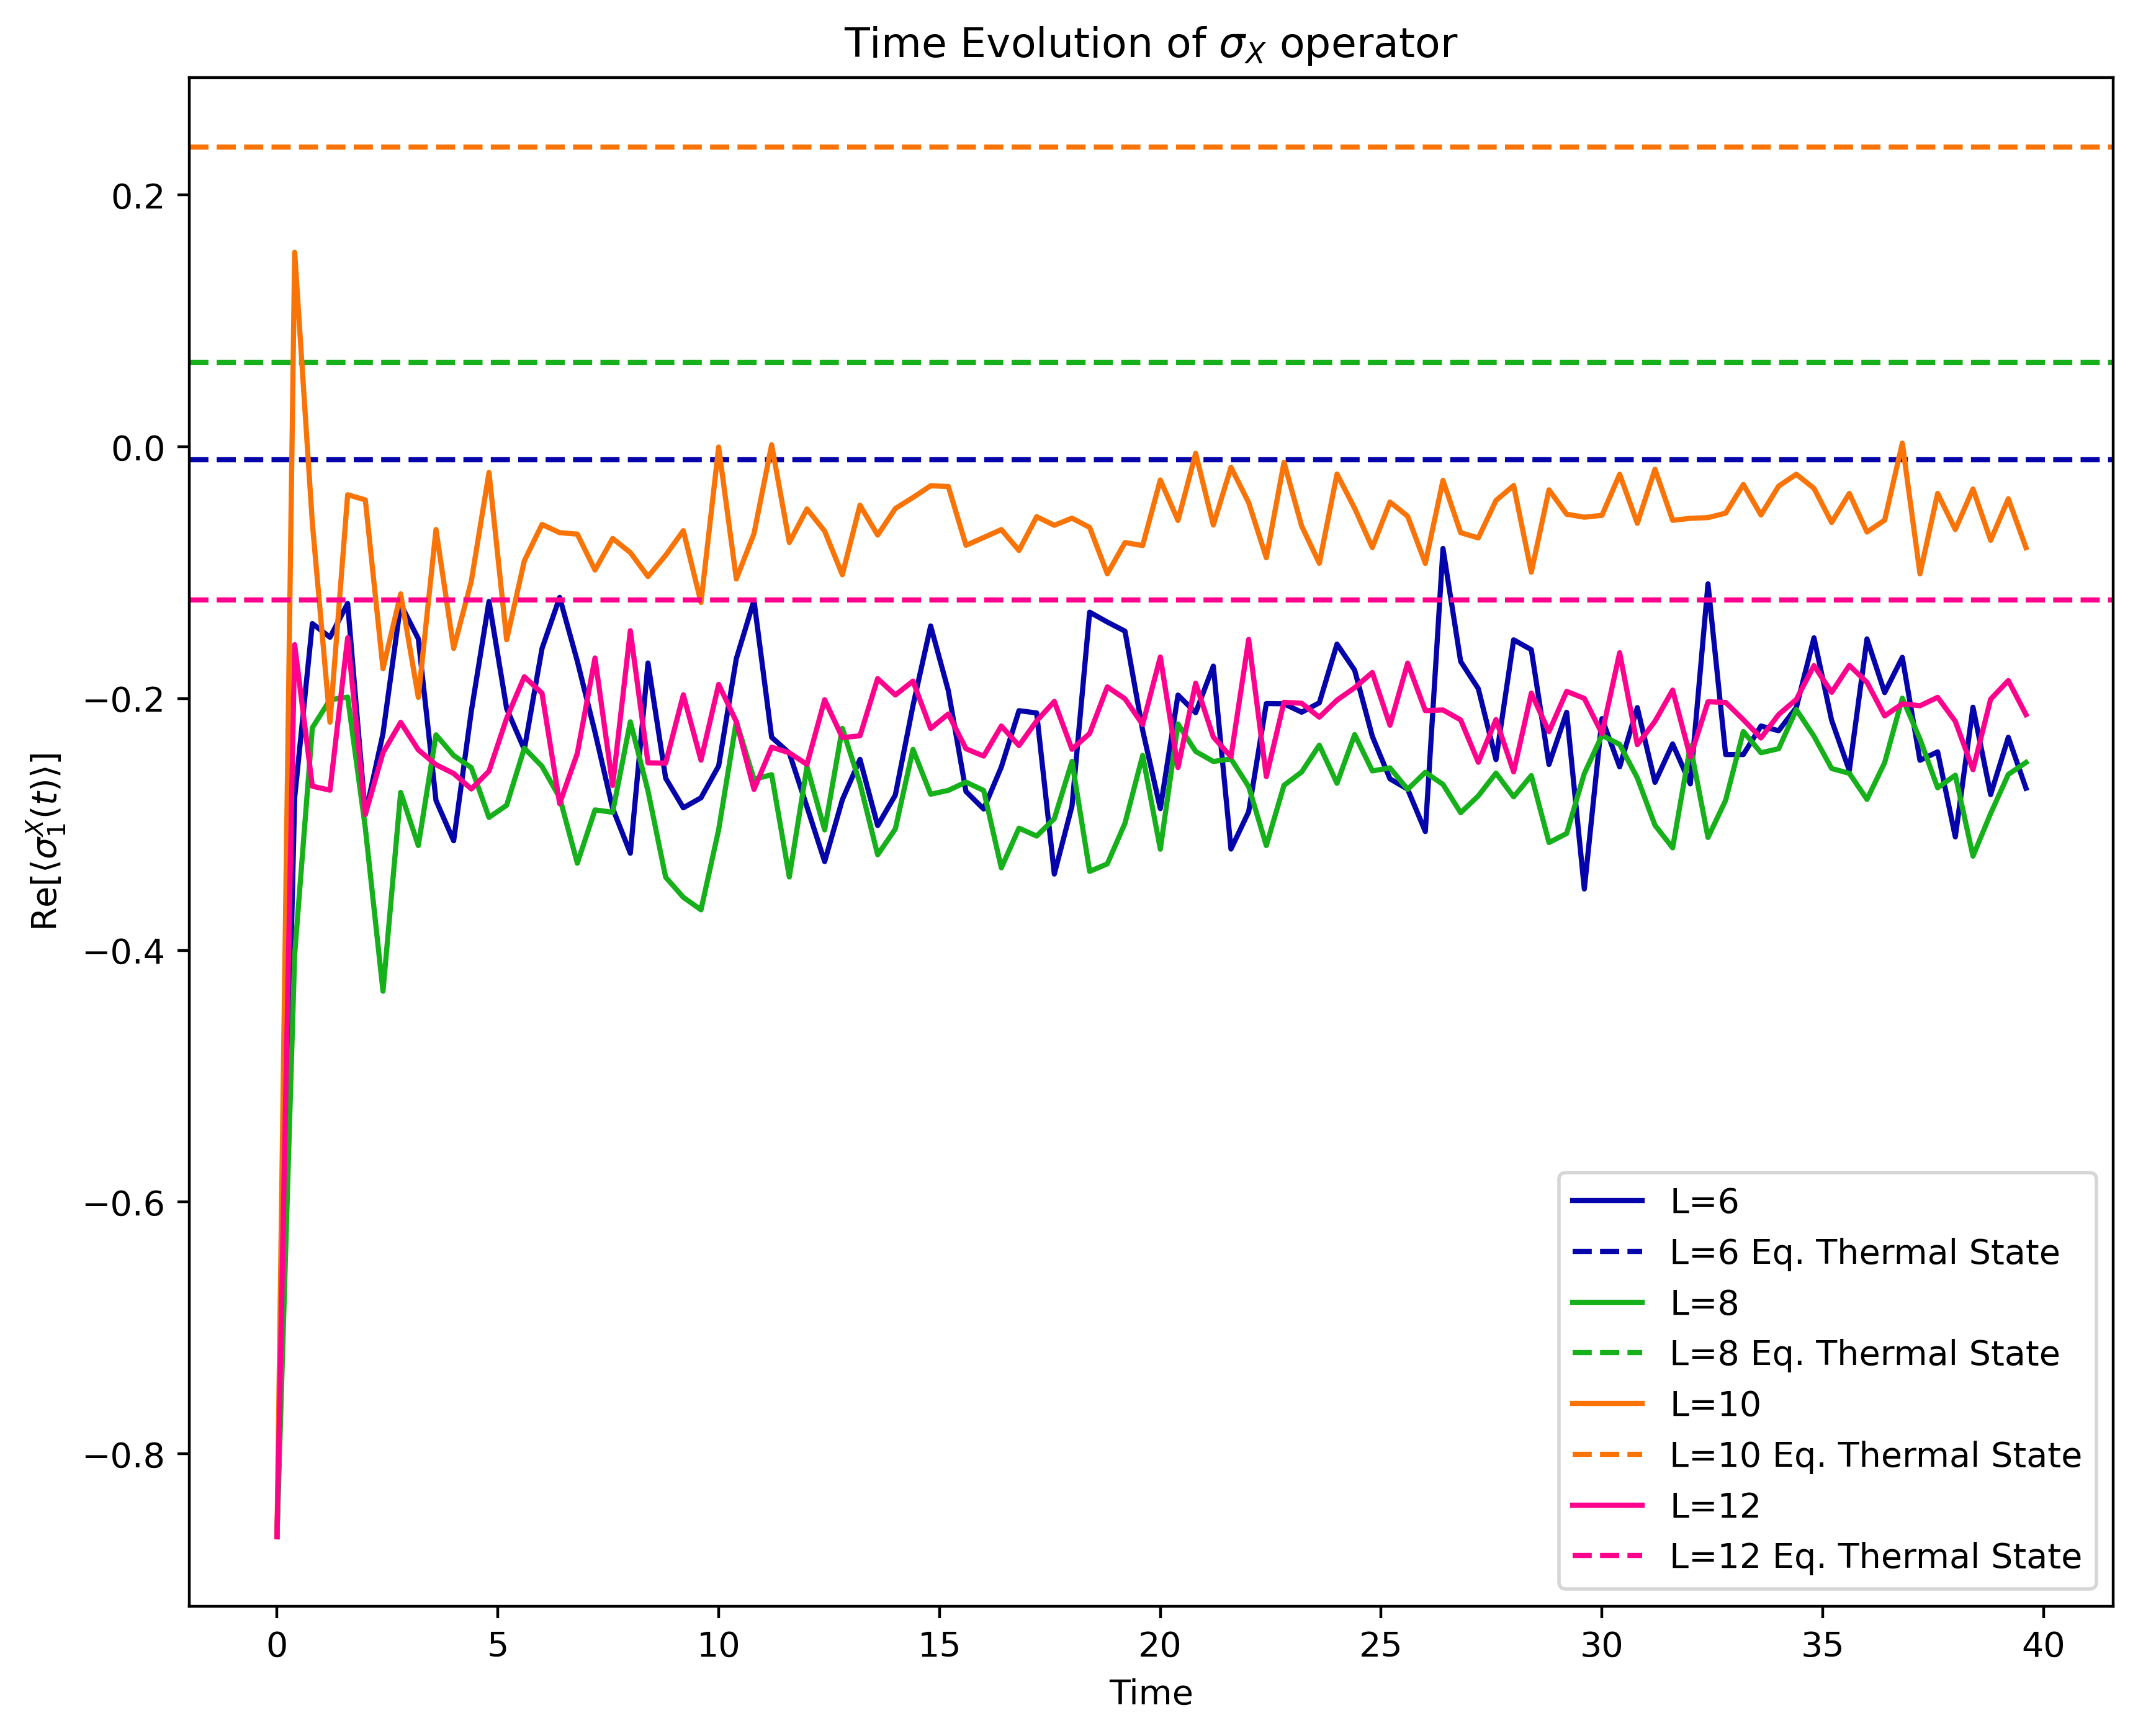

In [69]:
dt = .4
T = np.arange(0, 40, dt)
plt.figure(figsize=(10, 8))

for i in range(len(Ls)):
    L = Ls[i]
    avg_Yarray = np.zeros(len(T))
    avg_sigma_thermal = 0.0
    count = 0
    
    for j in tqdm(range(num_realizations), desc=f'Processing L={L}'):
        eigs = all_eigss[i][j]
        vecs = all_vecss[i][j]
        psi = psi_initial(L)
        coeffs = vecs.conj().T @ psi
        sigma_matrix = sigma('x', vecs)

        Yarray = []
        for t in T:
            Yarray.append(expectation_value(sigma_matrix, eigs, coeffs, t))
        
        avg_Yarray += np.array(Yarray)
        avg_sigma_thermal += sigma_thermal('x', eigs, vecs, 0.374)
        count += 1
    
    avg_Yarray /= count
    avg_sigma_thermal /= count

    xkcd_colors = ['xkcd:royal blue', 'xkcd:green', 'xkcd:orange', 'xkcd:hot pink']

    plt.plot(T, avg_Yarray, label=f'L={L}', color=xkcd_colors[i])
    plt.axhline(y=avg_sigma_thermal, color=xkcd_colors[i], linestyle='--', label=f'L={L} Eq. Thermal State')

plt.xlabel('Time')
plt.ylabel(r'Re[$\langle \sigma_1^X (t) \rangle$]')
plt.title(r'Time Evolution of $\sigma_X$ operator')
plt.legend()
plt.savefig(os.path.join(directory, 'sigmaxMBL.png'), dpi=400)
plt.show()


Processing L=6:   0%|          | 0/10 [00:00<?, ?it/s]

Processing L=8:   0%|          | 0/10 [00:00<?, ?it/s]

Processing L=10:   0%|          | 0/10 [00:00<?, ?it/s]

Processing L=12:   0%|          | 0/10 [00:00<?, ?it/s]

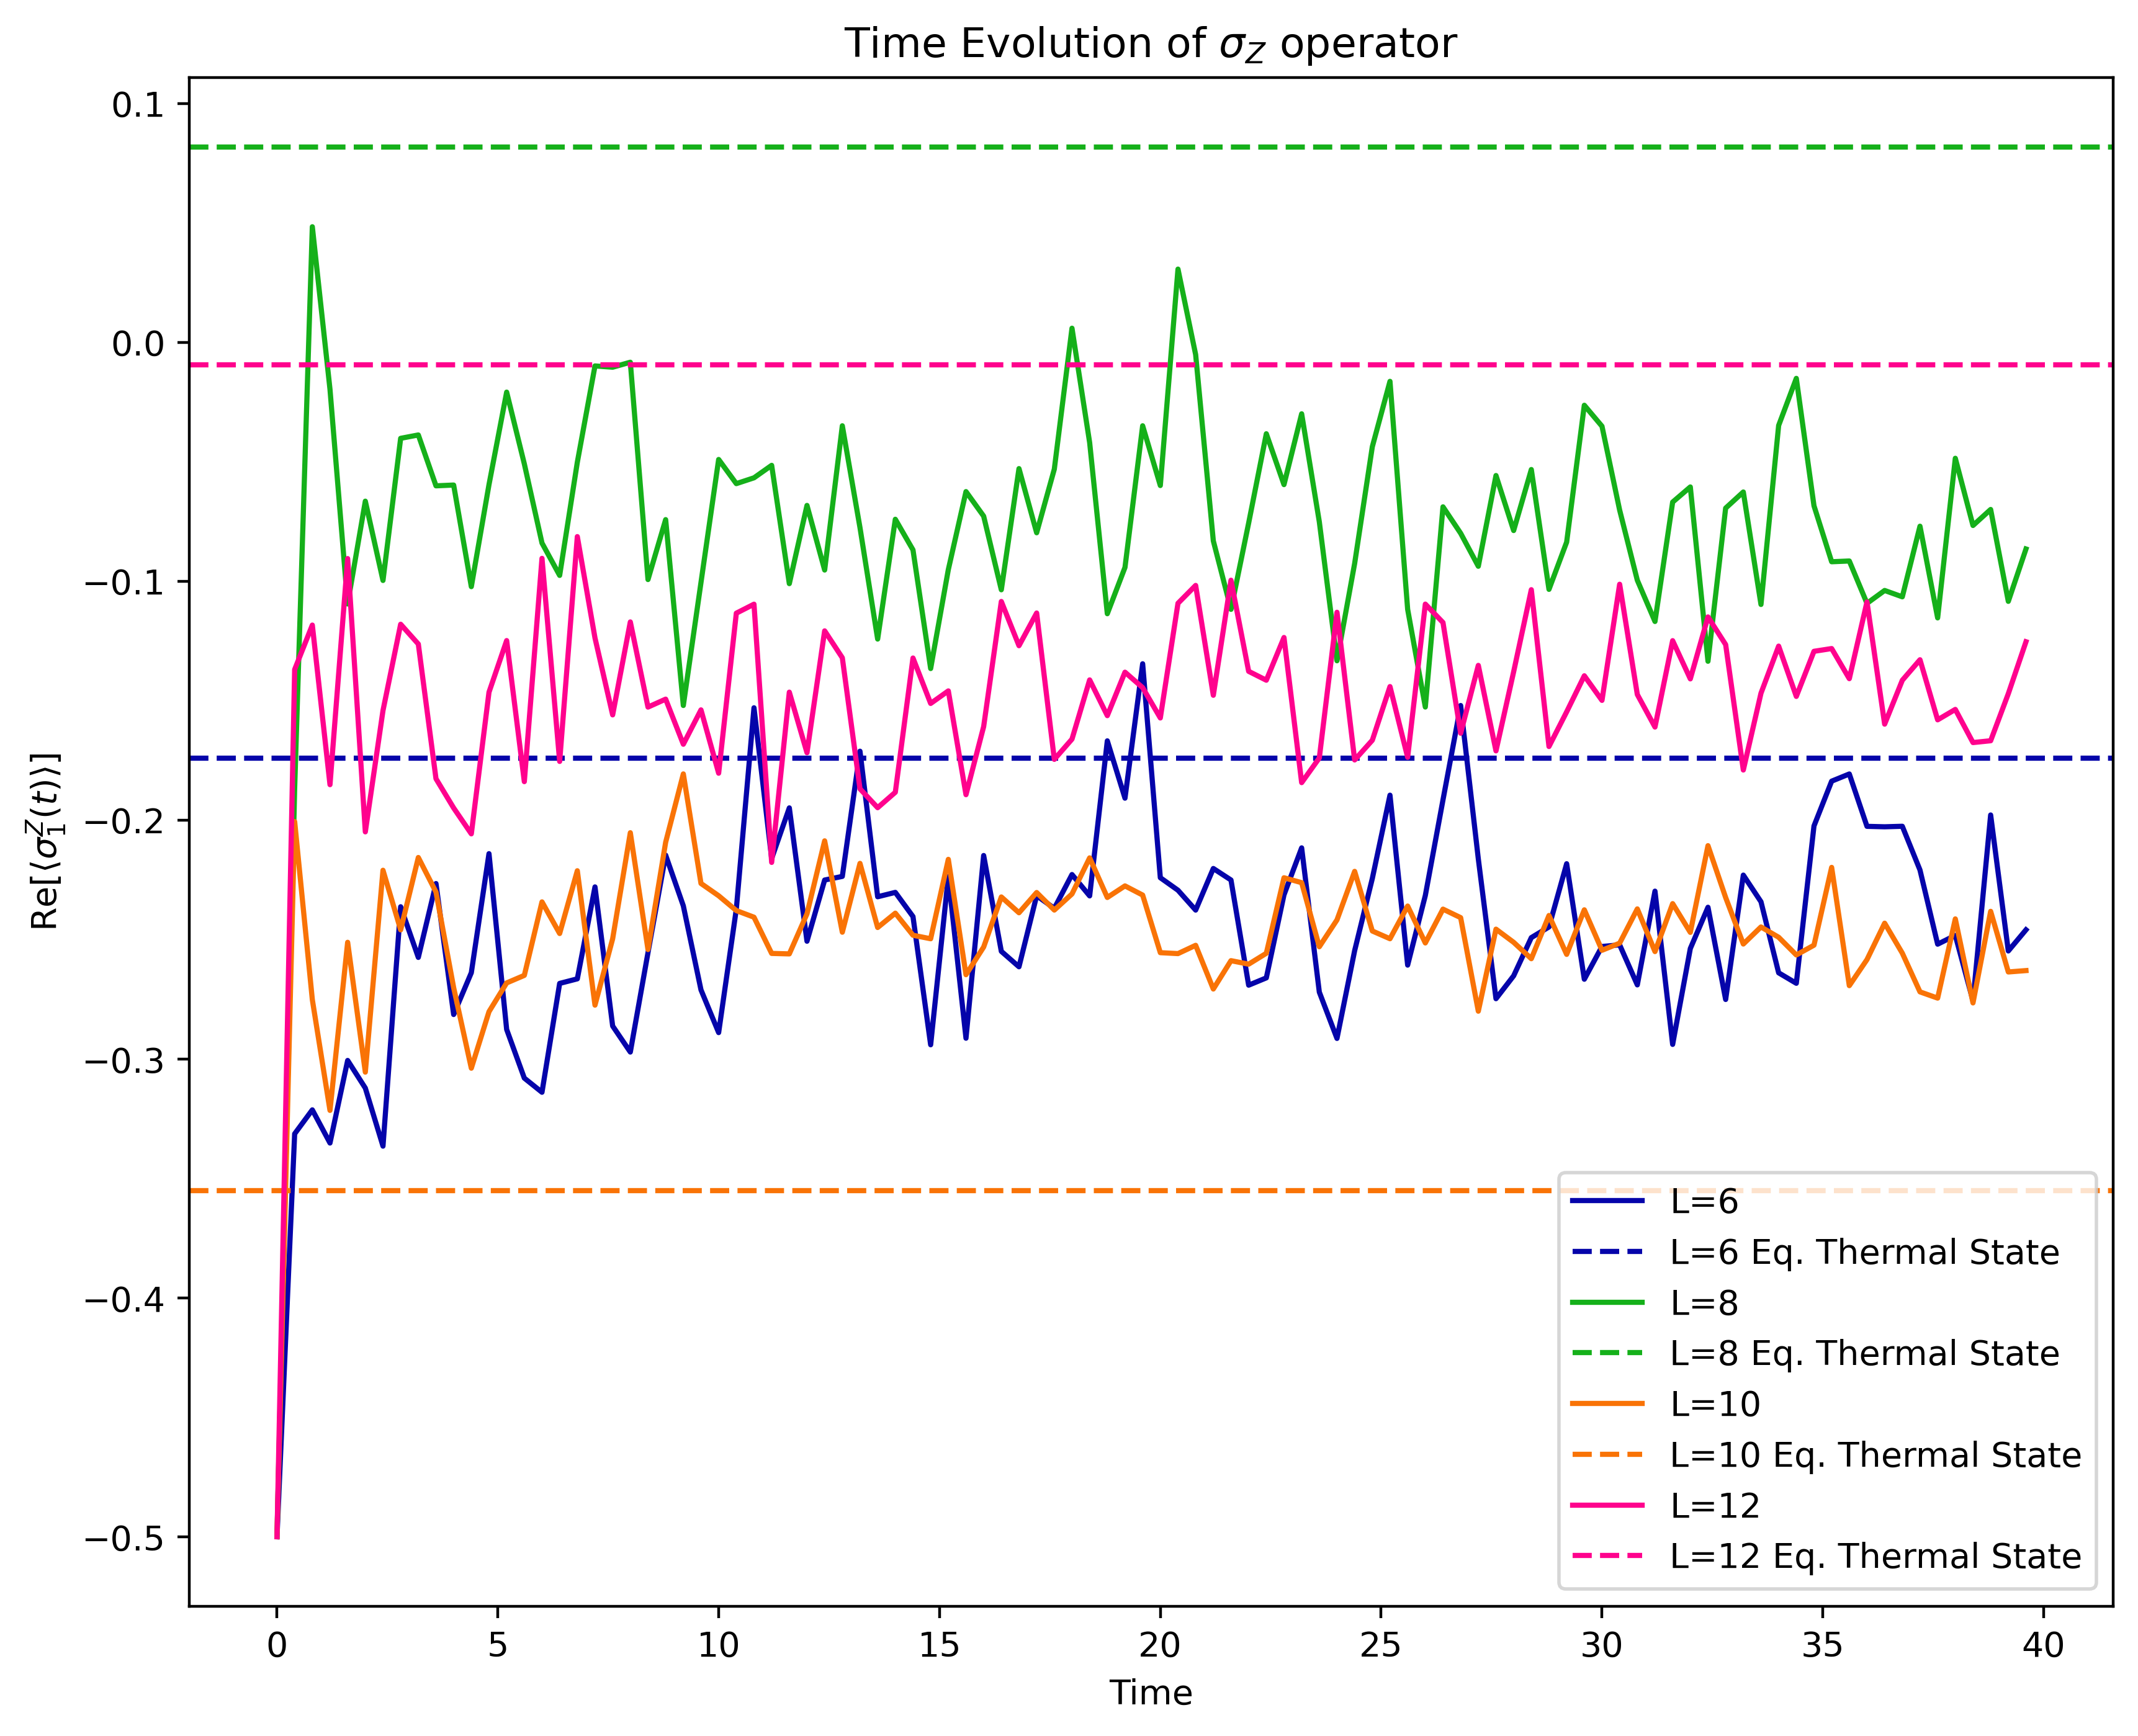

In [73]:
dt = .4
T = np.arange(0, 40, dt)
plt.figure(figsize=(10, 8))

for i in range(len(Ls)):
    L = Ls[i]
    avg_Yarray = np.zeros(len(T))
    avg_sigma_thermal = 0.0
    count = 0
    
    for j in tqdm(range(num_realizations), desc=f'Processing L={L}'):
        eigs = all_eigss[i][j]
        vecs = all_vecss[i][j]
        psi = psi_initial(L)
        coeffs = vecs.conj().T @ psi
        sigma_matrix = sigma('z', vecs)

        Yarray = []
        for t in T:
            Yarray.append(expectation_value(sigma_matrix, eigs, coeffs, t))
        
        avg_Yarray += np.array(Yarray)
        avg_sigma_thermal += sigma_thermal('z', eigs, vecs, 0.374)
        count += 1
    
    avg_Yarray /= count
    avg_sigma_thermal /= count

    xkcd_colors = ['xkcd:royal blue', 'xkcd:green', 'xkcd:orange', 'xkcd:hot pink']

    plt.plot(T, avg_Yarray, label=f'L={L}', color=xkcd_colors[i])
    plt.axhline(y=avg_sigma_thermal, color=xkcd_colors[i], linestyle='--', label=f'L={L} Eq. Thermal State')

plt.xlabel('Time')
plt.ylabel(r'Re[$\langle \sigma_1^Z (t) \rangle$]')
plt.title(r'Time Evolution of $\sigma_Z$ operator')
plt.legend()
plt.savefig(os.path.join(directory, 'sigmazMBL.png'), dpi=400)
plt.show()


Processing L=6:   0%|          | 0/10 [00:00<?, ?it/s]

Processing L=8:   0%|          | 0/10 [00:00<?, ?it/s]

Processing L=10:   0%|          | 0/10 [00:00<?, ?it/s]

Processing L=12:   0%|          | 0/10 [00:00<?, ?it/s]

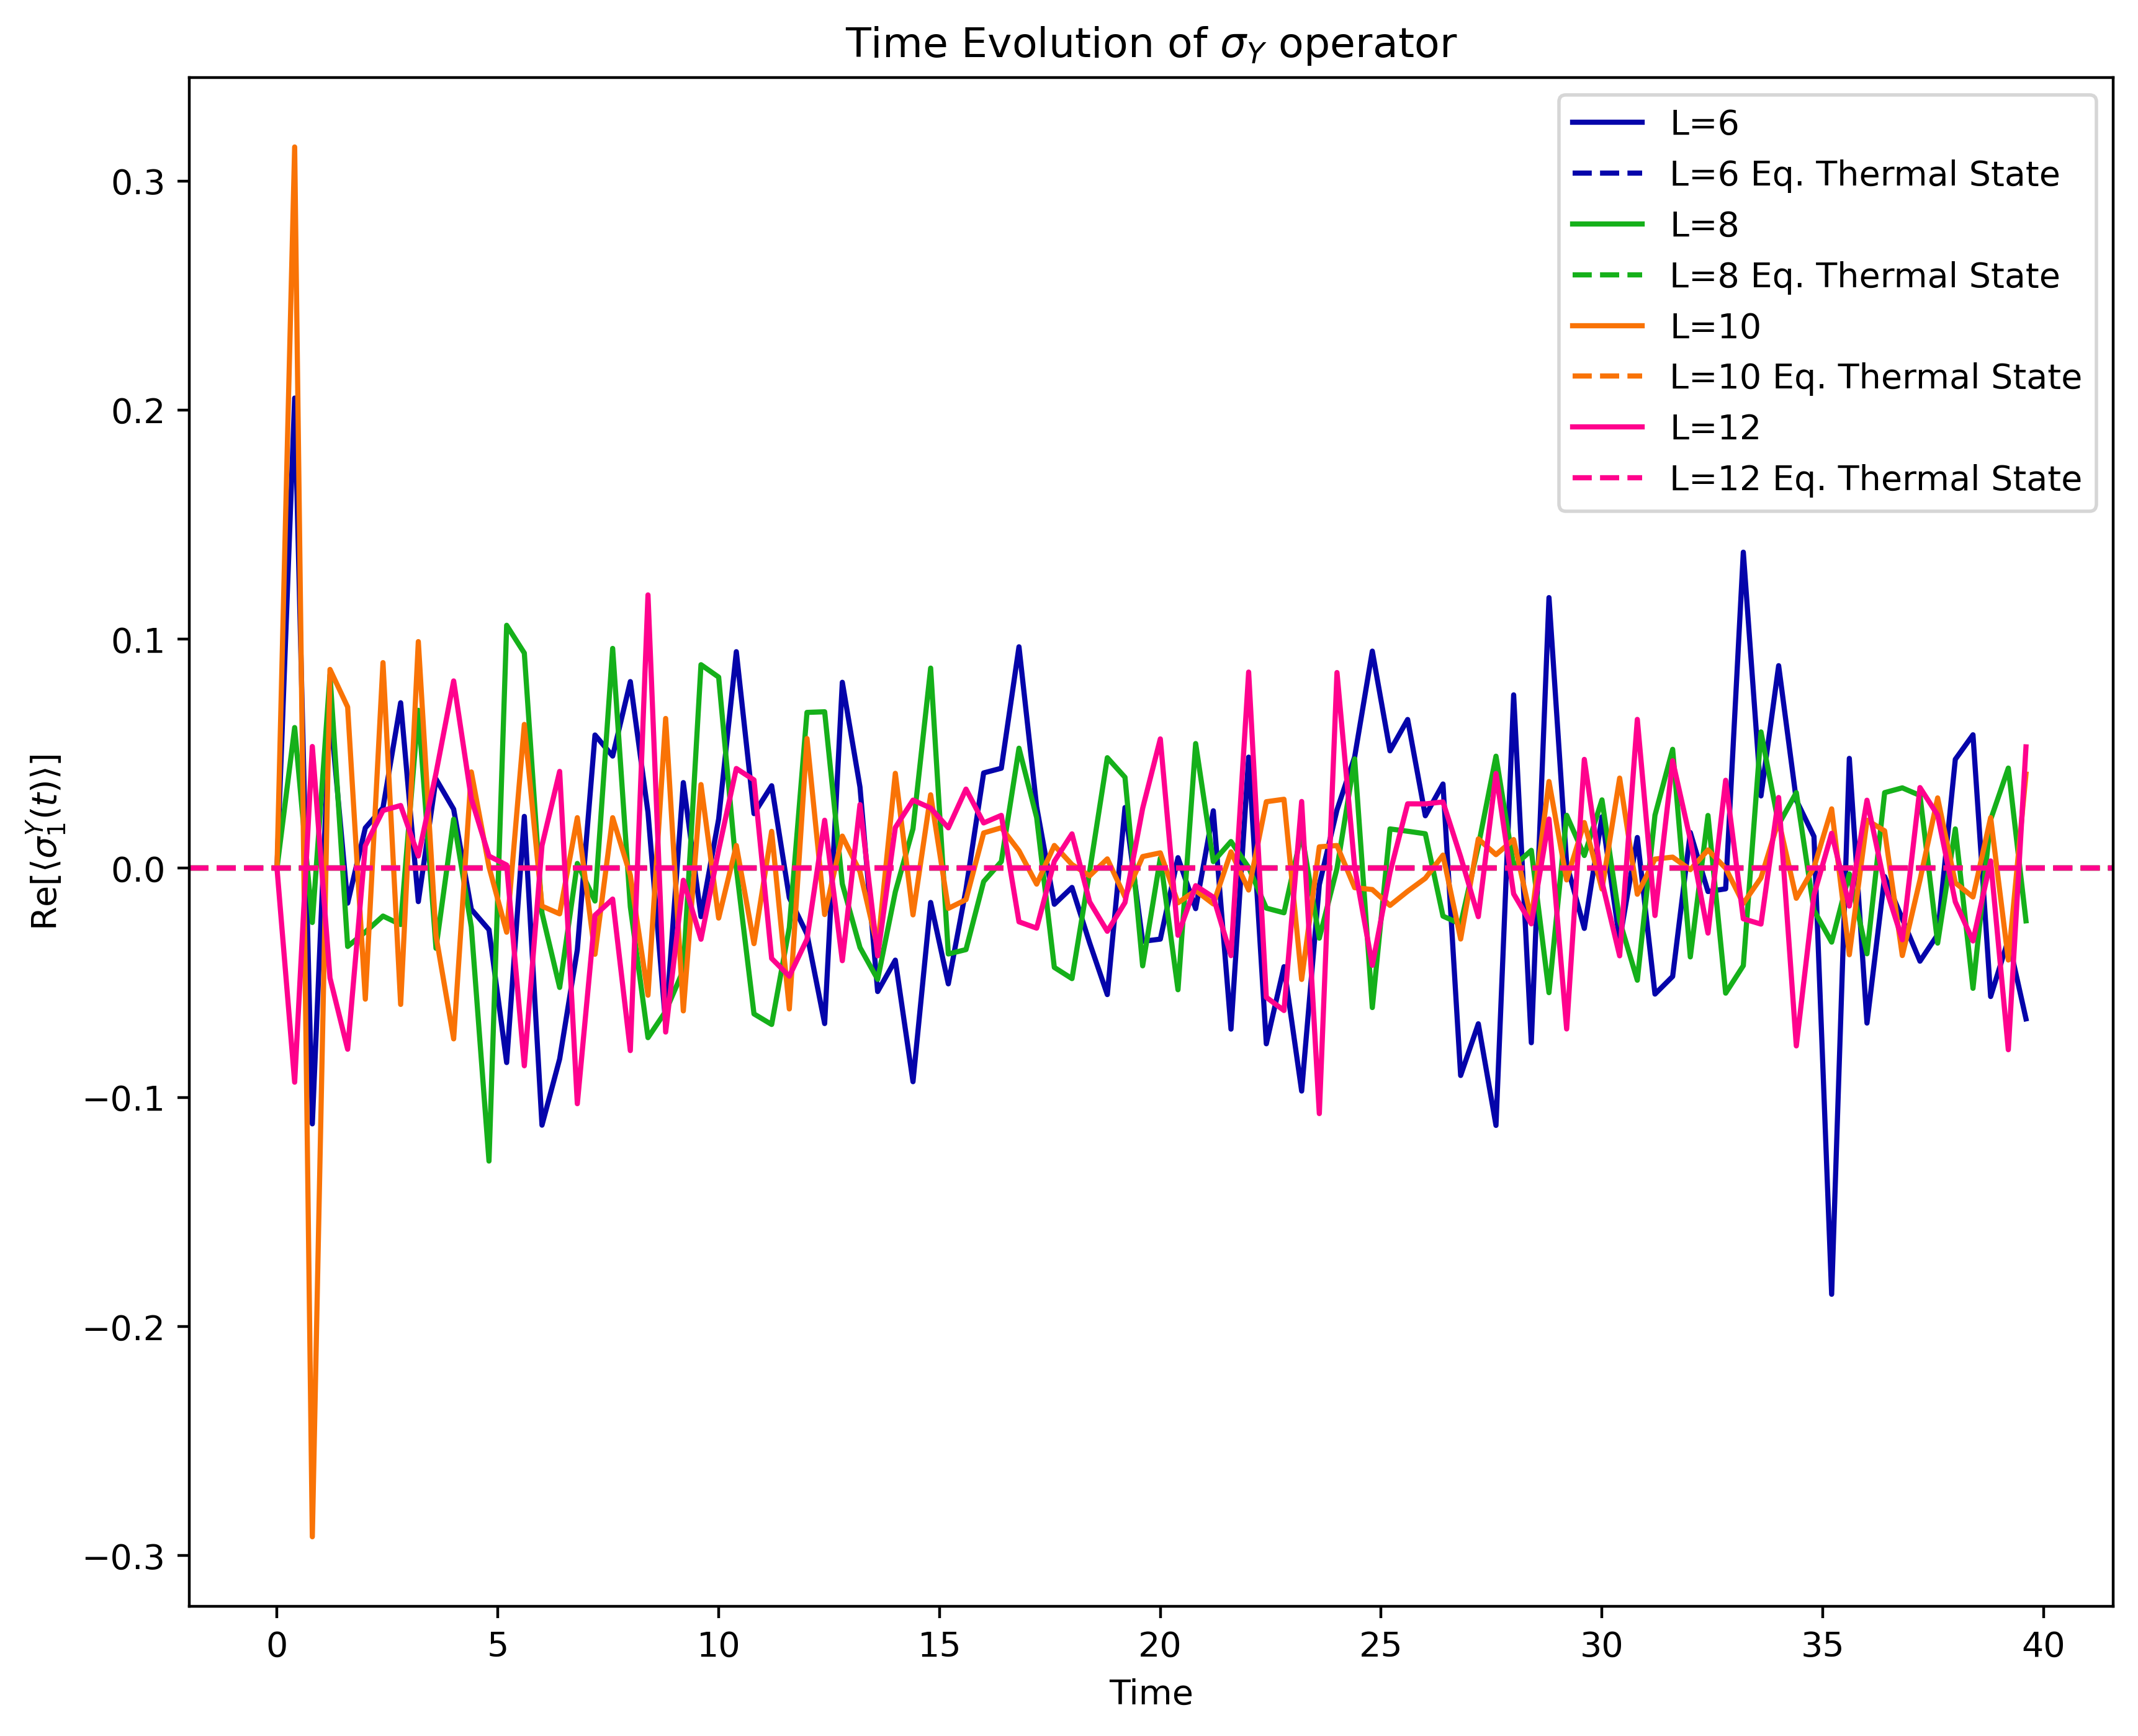

In [74]:
dt = .4
T = np.arange(0, 40, dt)
plt.figure(figsize=(10, 8))

for i in range(len(Ls)):
    L = Ls[i]
    avg_Yarray = np.zeros(len(T))
    avg_sigma_thermal = 0.0
    count = 0
    
    for j in tqdm(range(num_realizations), desc=f'Processing L={L}'):
        eigs = all_eigss[i][j]
        vecs = all_vecss[i][j]
        psi = psi_initial(L)
        coeffs = vecs.conj().T @ psi
        sigma_matrix = sigma('y', vecs)

        Yarray = []
        for t in T:
            Yarray.append(expectation_value(sigma_matrix, eigs, coeffs, t))
        
        avg_Yarray += np.array(Yarray)
        avg_sigma_thermal += sigma_thermal('y', eigs, vecs, 0.374)
        count += 1
    
    avg_Yarray /= count
    avg_sigma_thermal /= count

    xkcd_colors = ['xkcd:royal blue', 'xkcd:green', 'xkcd:orange', 'xkcd:hot pink']

    plt.plot(T, avg_Yarray, label=f'L={L}', color=xkcd_colors[i])
    plt.axhline(y=avg_sigma_thermal, color=xkcd_colors[i], linestyle='--', label=f'L={L} Eq. Thermal State')

plt.xlabel('Time')
plt.ylabel(r'Re[$\langle \sigma_1^Y (t) \rangle$]')
plt.title(r'Time Evolution of $\sigma_Y$ operator')
plt.legend()
plt.savefig(os.path.join(directory, 'sigmayMBL.png'), dpi=400)
plt.show()


In [75]:
def entanglement_entropy(L, l, coeffs, eigs, vecs, t):

    coeffs_new = coeffs * np.exp(-1j * eigs * t).reshape(-1, 1)

    psi_t = vecs @ coeffs_new 
    psi_t_matrix = psi_t.reshape(2**l, 2**(L-l))
    u, s, vh = np.linalg.svd(psi_t_matrix, compute_uv=True)
    lambdas = s**2
    S = -np.sum(lambdas * np.log(lambdas))
    
    return S

Processing realizations for L=6:   0%|          | 0/10 [00:00<?, ?it/s]

Processing realizations for L=8:   0%|          | 0/10 [00:00<?, ?it/s]

Processing realizations for L=10:   0%|          | 0/10 [00:00<?, ?it/s]

Processing realizations for L=12:   0%|          | 0/10 [00:00<?, ?it/s]

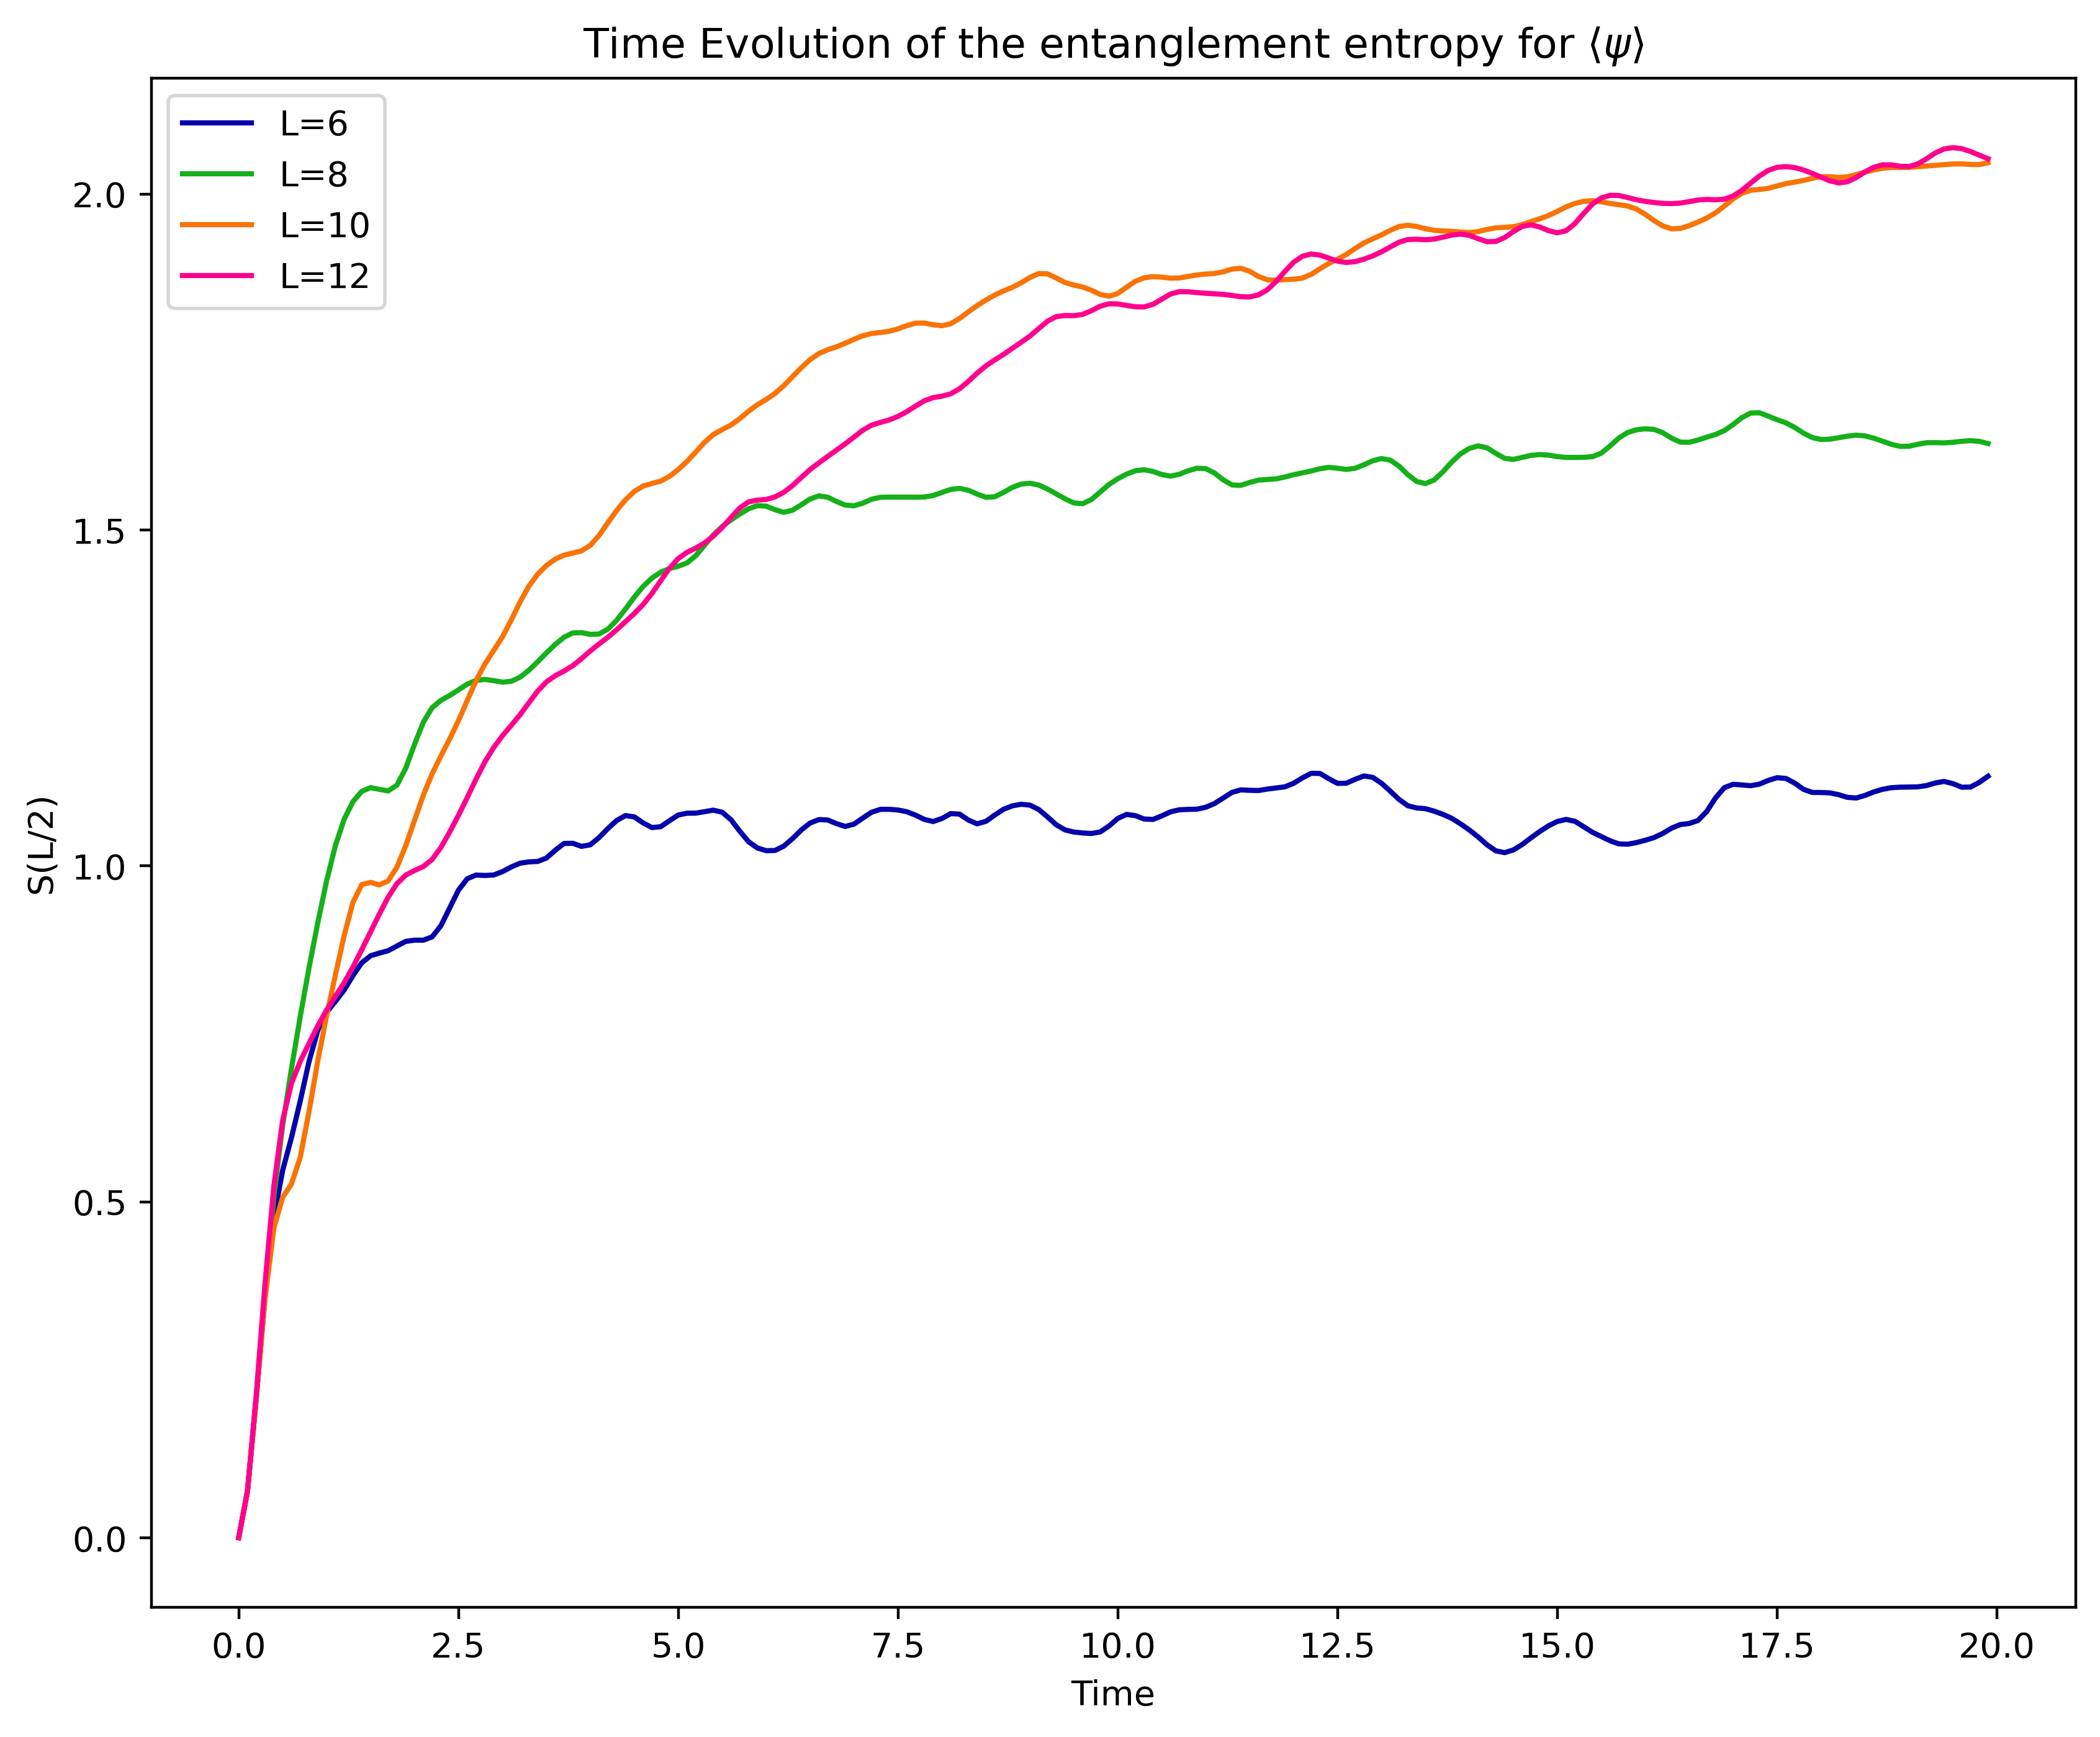

In [77]:
dt = .1
T = np.arange(0,20, dt)

plt.figure(figsize=(10, 8))

for i in range(len(Ls)):
    L = Ls[i]
    avg_Yarray = np.zeros(len(T))
    count = 0
    

    for j in tqdm(range(num_realizations), desc=f'Processing realizations for L={L}'):
        eigs = all_eigss[i][j]
        vecs = all_vecss[i][j]
        psi = psi_initial(L)
        coeffs = vecs.conj().T @ psi
        
        Yarray = []
        for t in T:
            Yarray.append(entanglement_entropy(L, L//2, coeffs, eigs, vecs, t))
        
        avg_Yarray += np.array(Yarray)
        count += 1
    
    avg_Yarray /= count

    xkcd_colors = ['xkcd:royal blue', 'xkcd:green', 'xkcd:orange', 'xkcd:hot pink', 'xkcd:indigo']
    plt.plot(T, avg_Yarray, label=f'L={L}', color=xkcd_colors[i % len(xkcd_colors)])

plt.xlabel('Time')
plt.ylabel(r'S(L/2)')
plt.title(r'Time Evolution of the entanglement entropy for $\langle \psi \rangle$')
plt.legend()
plt.savefig(os.path.join(directory, 'entropy_psiMBL.png'), dpi=400)
plt.show()

In [79]:
def sigma_vec(mu, vec):
    sigma_vec = np.zeros(len(vec), dtype=complex)
    for alpha in range(len(vec)):
        if mu == 'z':
            if alpha & 1:
                sigma_vec[alpha] -= vec[alpha]
            else:
                sigma_vec[alpha] = vec[alpha]
        elif mu == 'y':
            beta = alpha ^ 1
            if alpha & 1:
                sigma_vec[beta] = -1j * vec[alpha]
            else:
                sigma_vec[beta] = 1j * vec[alpha]
        elif mu == 'x':
            beta = alpha ^ (1 << 0)
            sigma_vec[beta] = vec[alpha]
    return sigma_vec

Processing L=6:   0%|          | 0/10 [00:00<?, ?it/s]

Processing L=8:   0%|          | 0/10 [00:00<?, ?it/s]

Processing L=10:   0%|          | 0/10 [00:00<?, ?it/s]

Processing L=12:   0%|          | 0/10 [00:00<?, ?it/s]

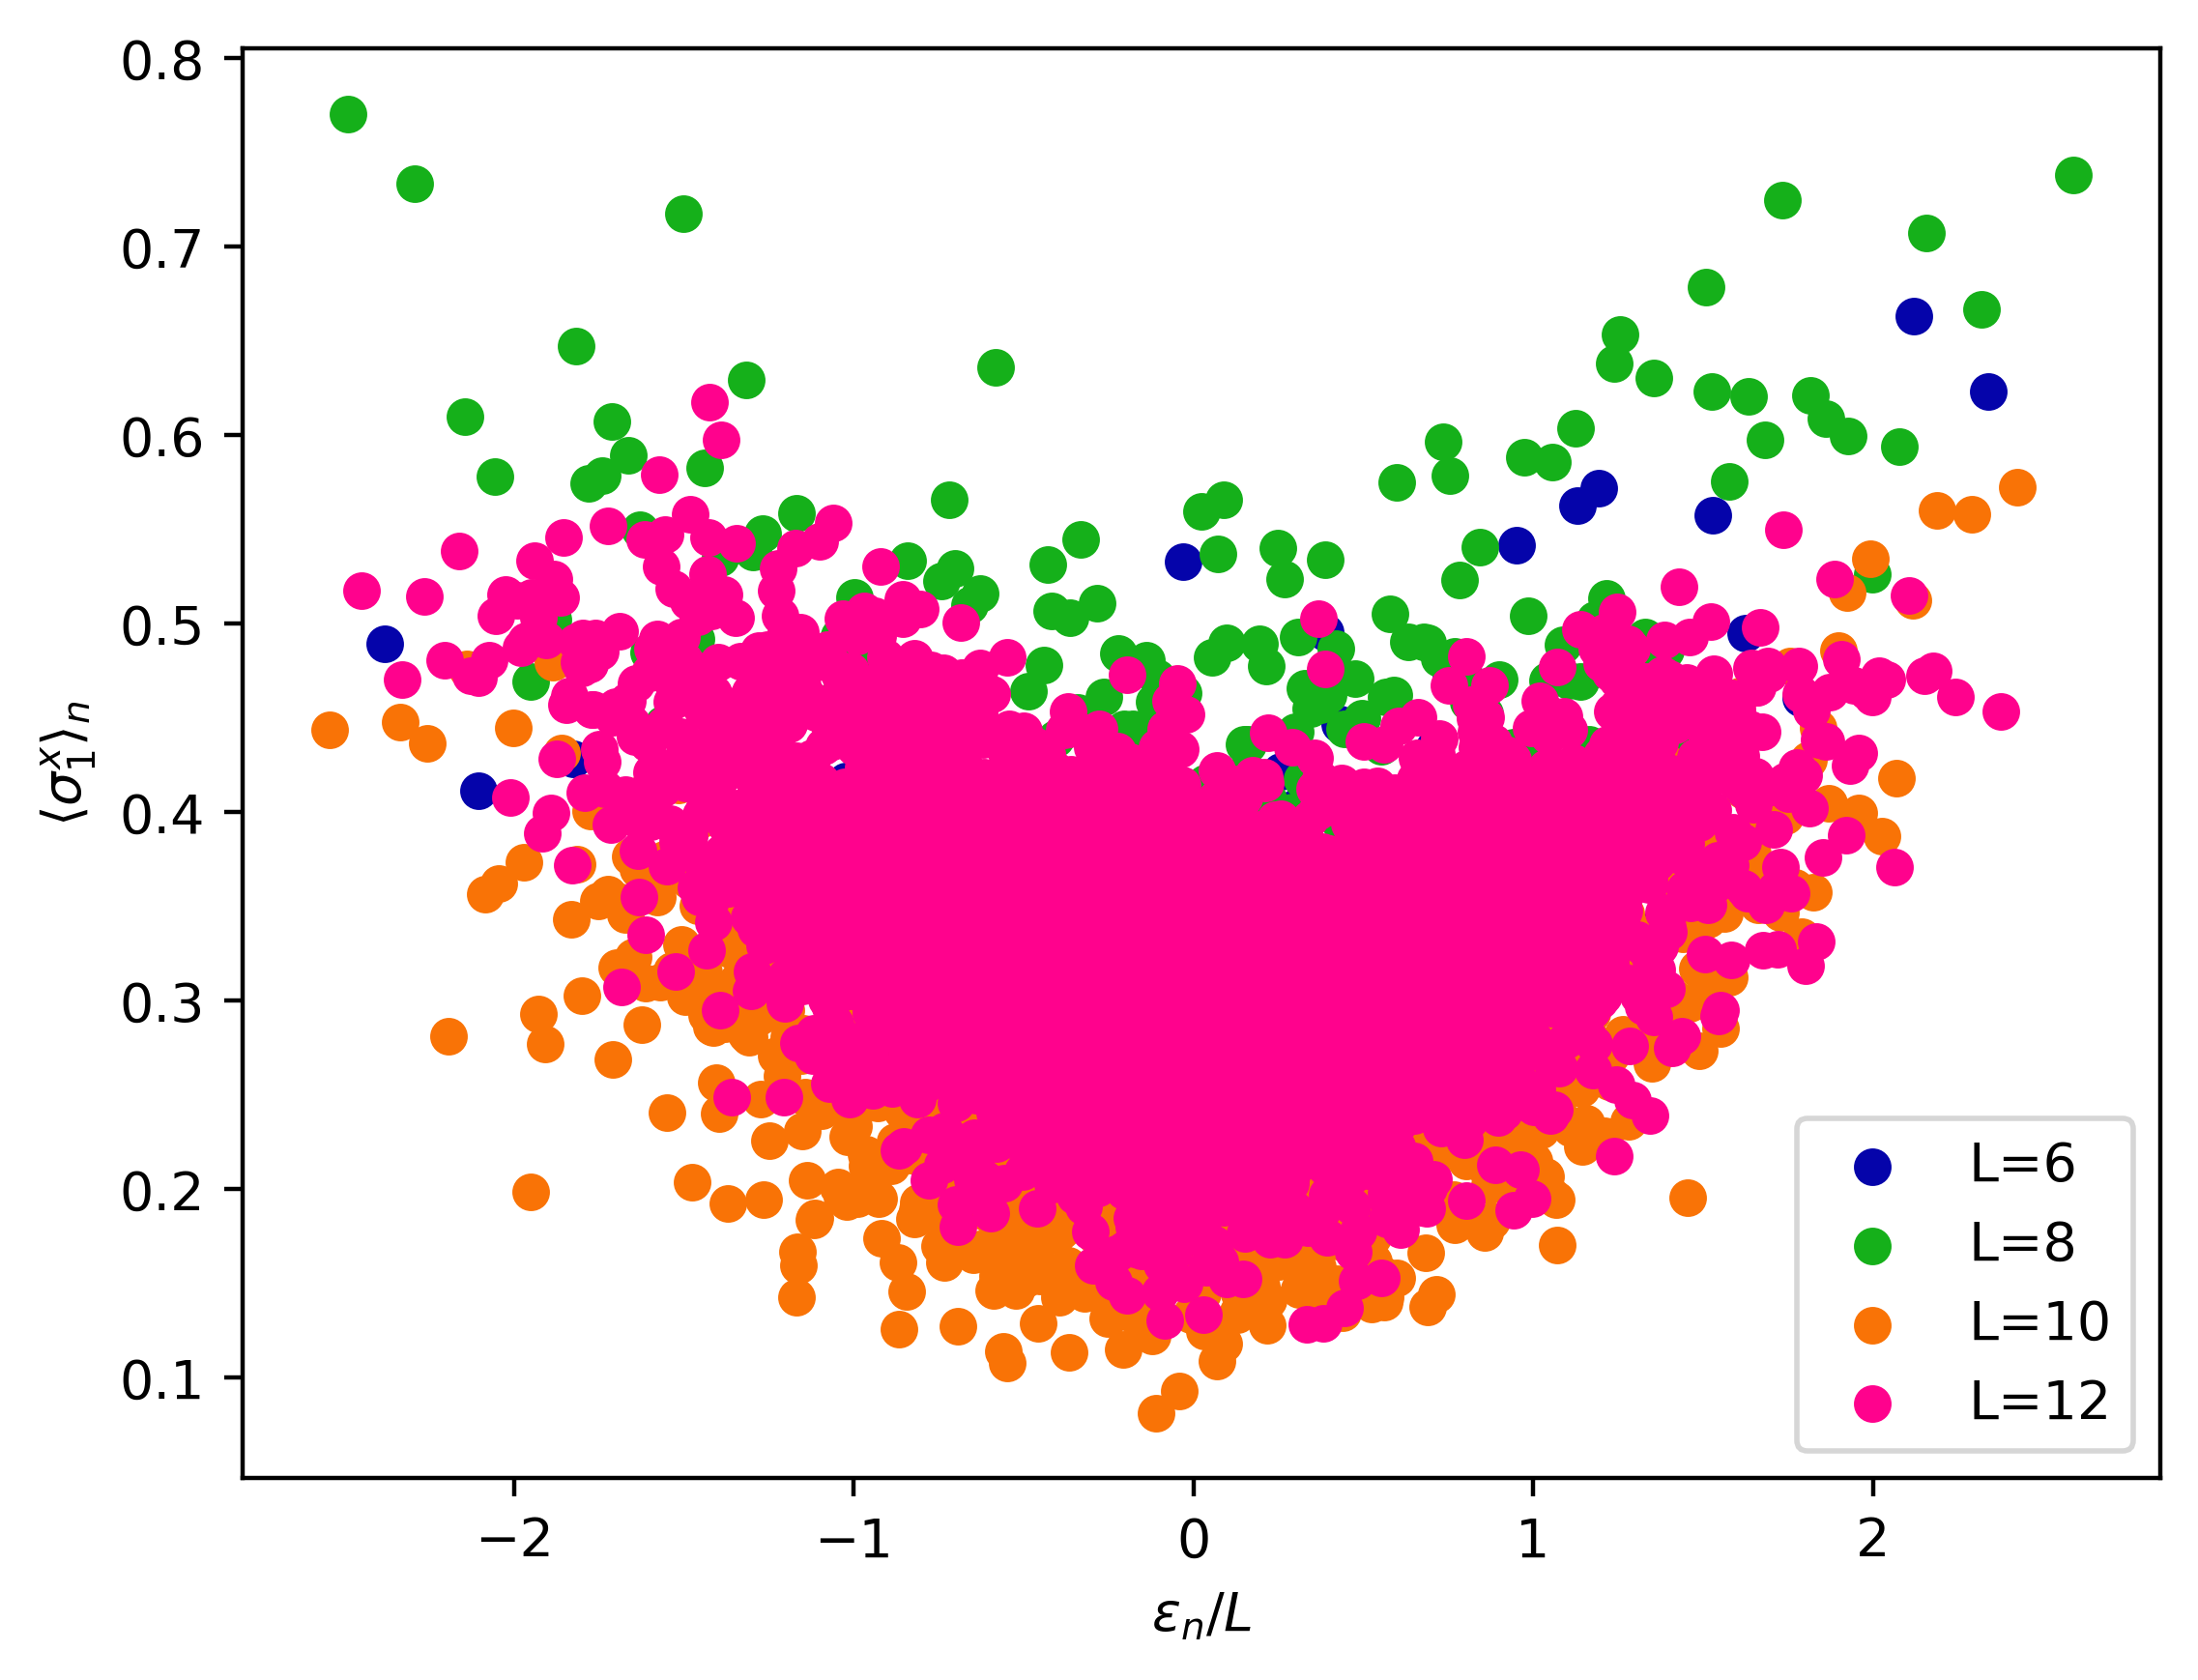

In [80]:
for i, L in enumerate(Ls):
    all_energies = []
    all_observables = []

    for j in tqdm(range(num_realizations), desc=f'Processing L={L}'):
        eigenvalues = all_eigss[i][j]
        eigenvectors = all_vecss[i][j]

        energies = eigenvalues / L
        observables = []

        for vec in eigenvectors.T:
            observable = abs(np.dot(vec.conj(), sigma_vec('x', vec)))
            observables.append(observable)

        all_energies.append(energies)
        all_observables.append(observables)

    # Averaging over realizations
    avg_energies = np.mean(all_energies, axis=0)
    avg_observables = np.mean(all_observables, axis=0)

    plt.scatter(avg_energies, avg_observables, label=f'L={L}', color=xkcd_colors[i])

plt.xlabel('$\epsilon_n / L$')
plt.ylabel('$\\langle \\sigma^{x}_1 \\rangle_n$')
plt.legend()
plt.savefig(os.path.join(directory, 'sigmax_average.png'), dpi=400)
plt.show()

Processing L=6:   0%|          | 0/10 [00:00<?, ?it/s]

Processing L=8:   0%|          | 0/10 [00:00<?, ?it/s]

Processing L=10:   0%|          | 0/10 [00:00<?, ?it/s]

Processing L=12:   0%|          | 0/10 [00:00<?, ?it/s]

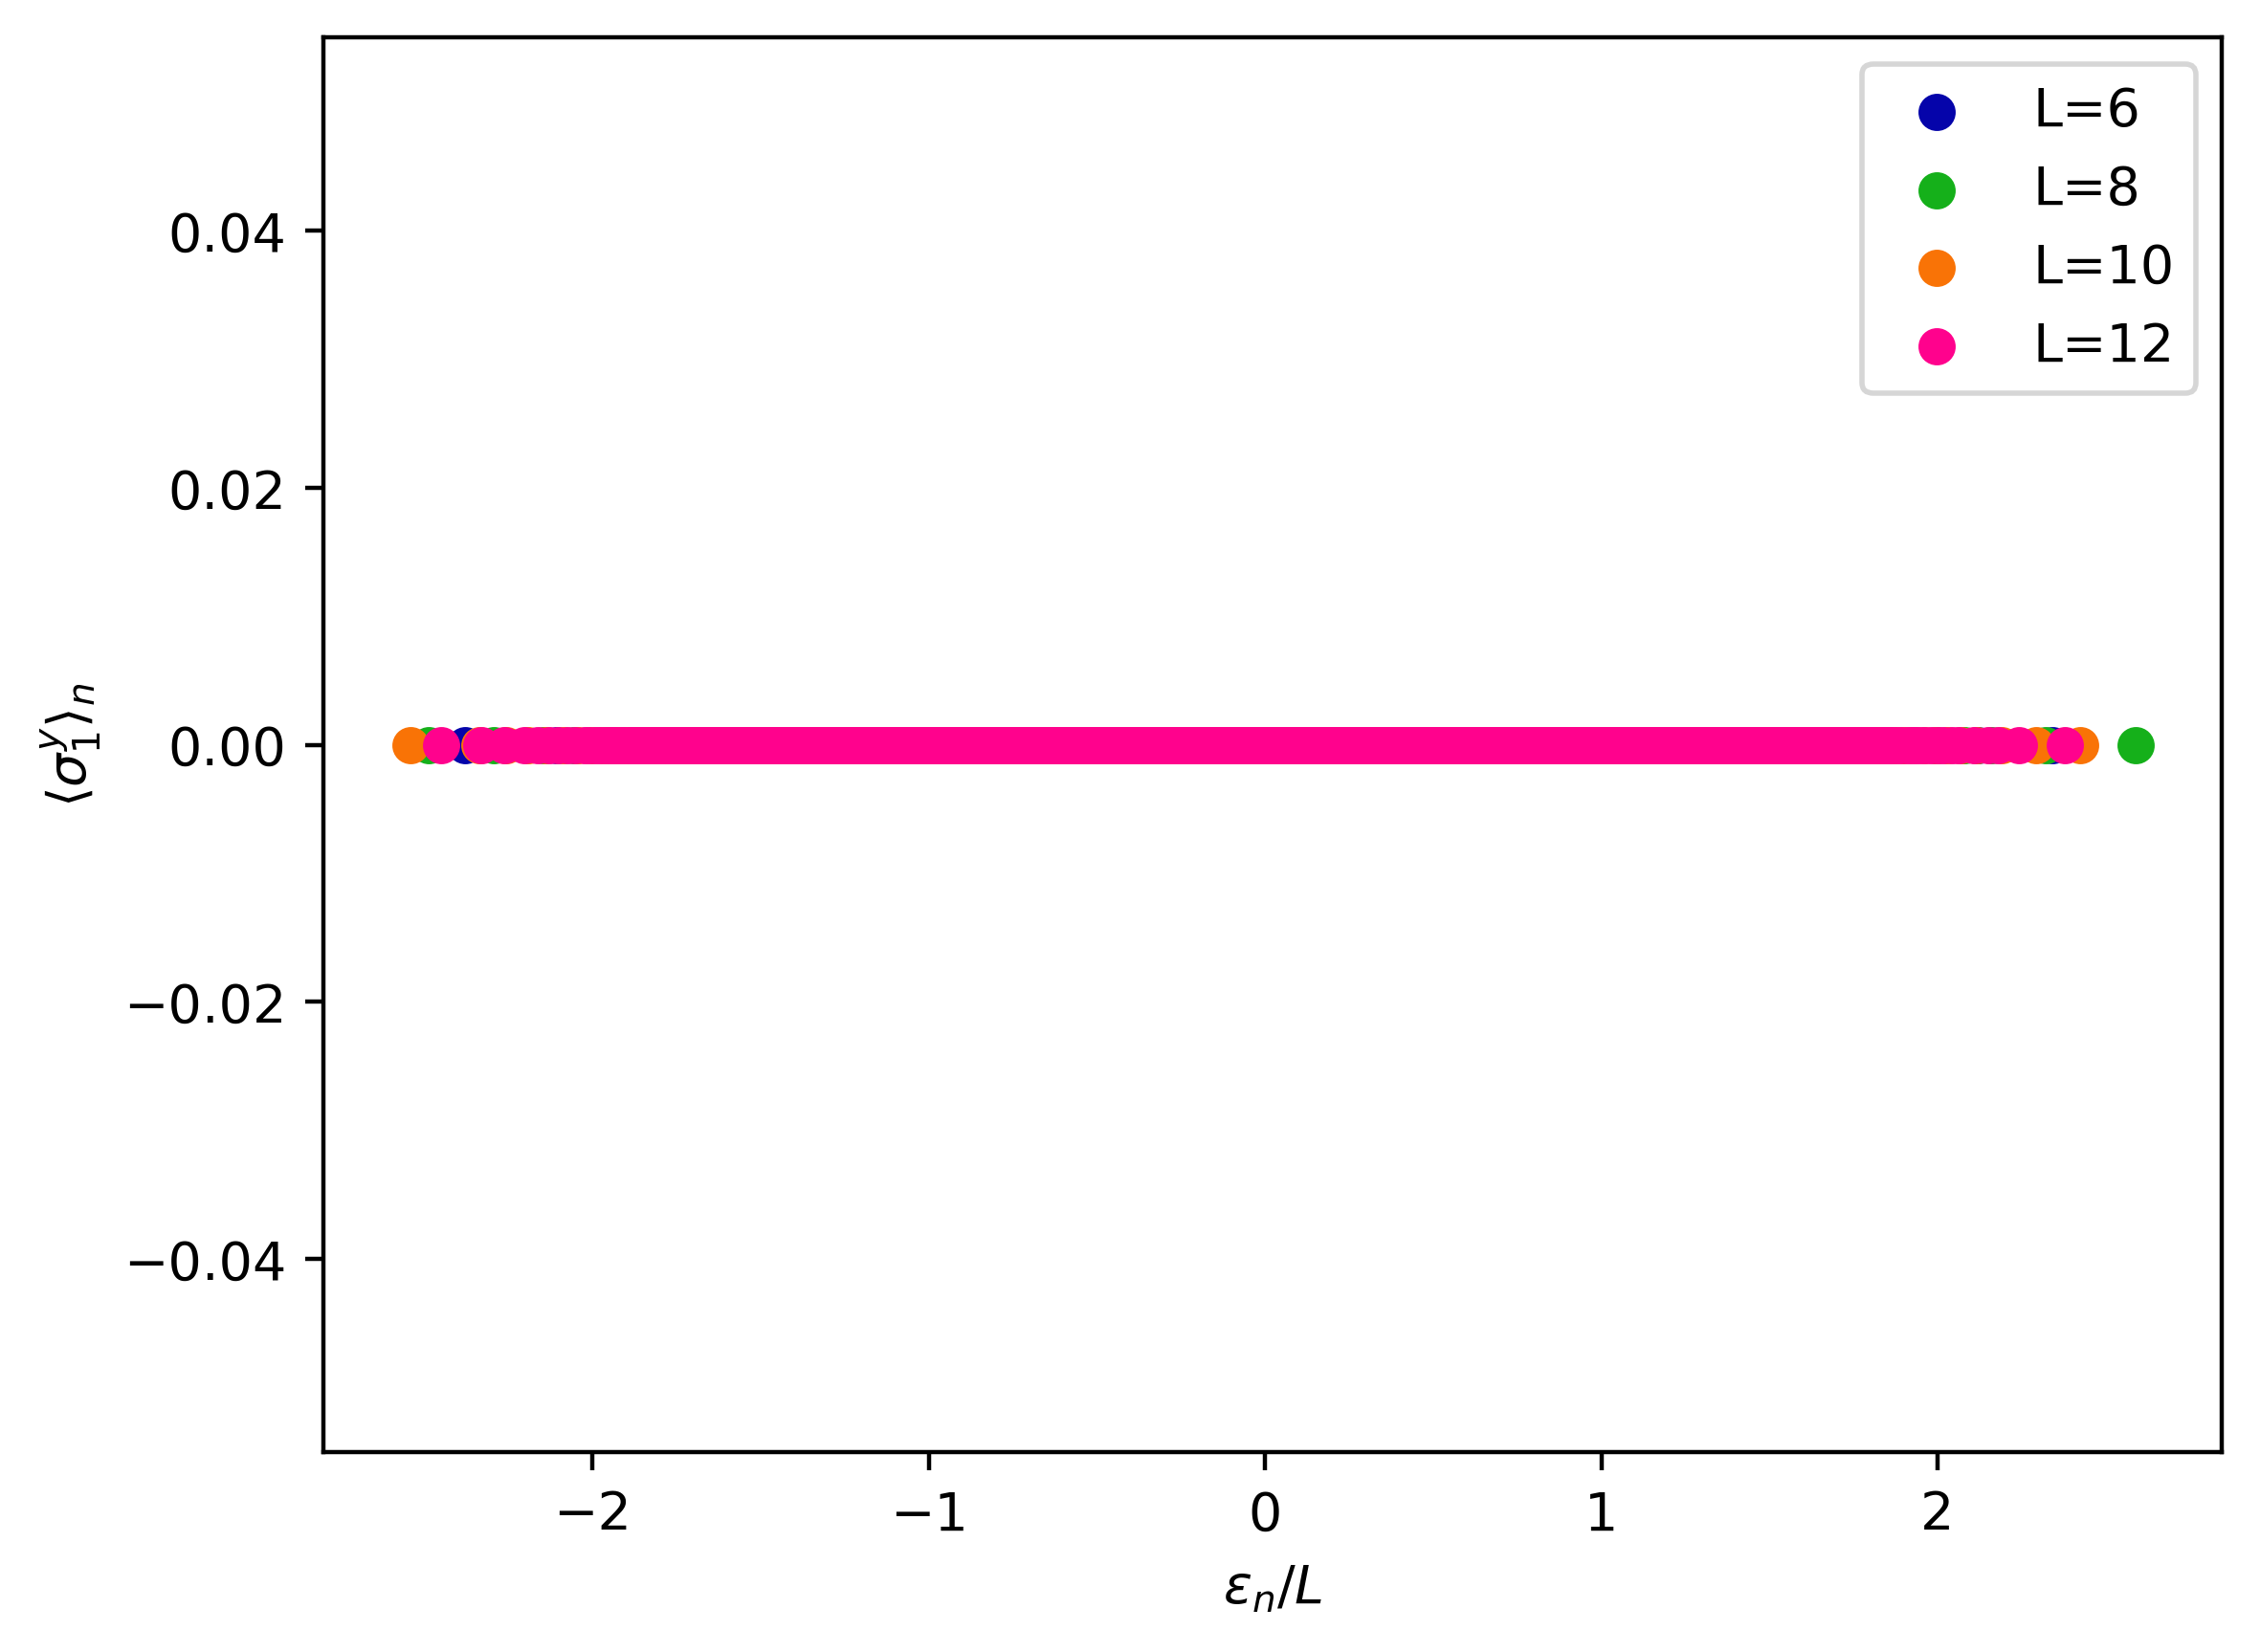

In [81]:
for i, L in enumerate(Ls):
    all_energies = []
    all_observables = []

    for j in tqdm(range(num_realizations), desc=f'Processing L={L}'):
        eigenvalues = all_eigss[i][j]
        eigenvectors = all_vecss[i][j]

        energies = eigenvalues / L
        observables = []

        for vec in eigenvectors.T:
            observable = abs(np.dot(vec.conj(), sigma_vec('y', vec)))
            observables.append(observable)

        all_energies.append(energies)
        all_observables.append(observables)

    # Averaging over realizations
    avg_energies = np.mean(all_energies, axis=0)
    avg_observables = np.mean(all_observables, axis=0)

    plt.scatter(avg_energies, avg_observables, label=f'L={L}', color=xkcd_colors[i])

plt.xlabel('$\epsilon_n / L$')
plt.ylabel('$\\langle \\sigma^{y}_1 \\rangle_n$')
plt.legend()
plt.savefig(os.path.join(directory, 'sigmay_average.png'), dpi=400)
plt.show()

Processing L=6:   0%|          | 0/10 [00:00<?, ?it/s]

Processing L=8:   0%|          | 0/10 [00:00<?, ?it/s]

Processing L=10:   0%|          | 0/10 [00:00<?, ?it/s]

Processing L=12:   0%|          | 0/10 [00:00<?, ?it/s]

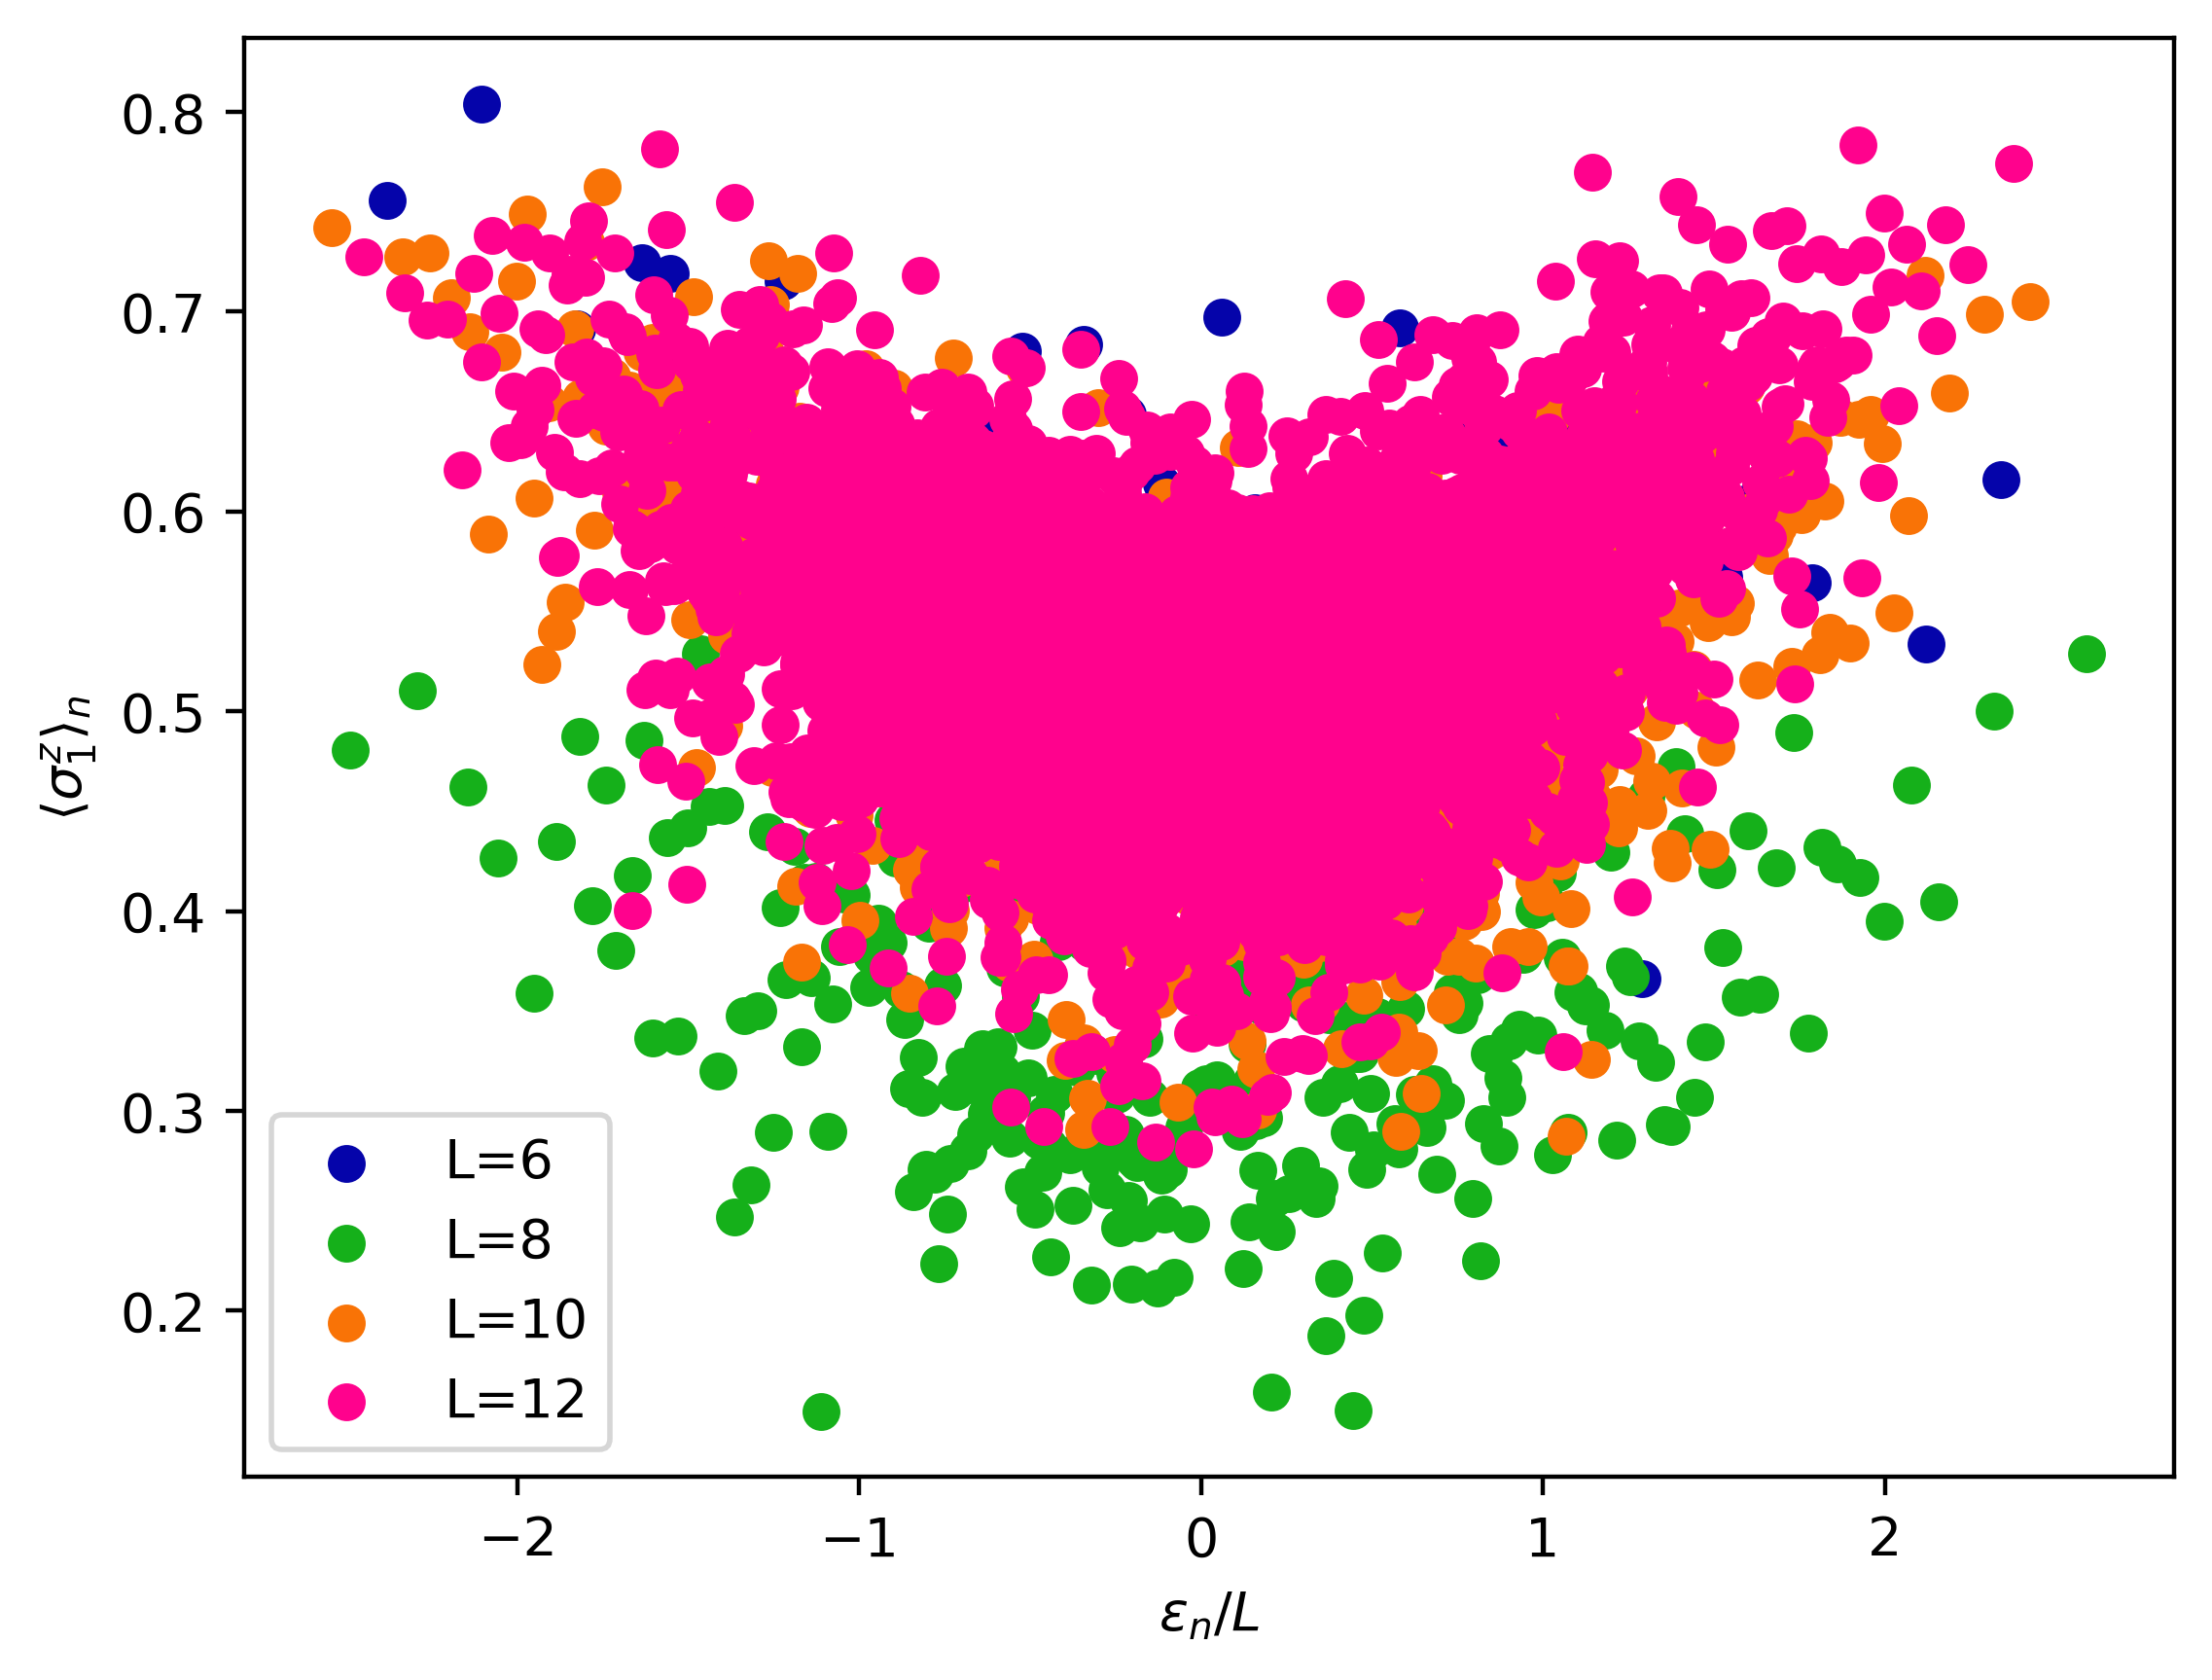

In [82]:
for i, L in enumerate(Ls):
    all_energies = []
    all_observables = []

    for j in tqdm(range(num_realizations), desc=f'Processing L={L}'):
        eigenvalues = all_eigss[i][j]
        eigenvectors = all_vecss[i][j]

        energies = eigenvalues / L
        observables = []

        for vec in eigenvectors.T:
            observable = abs(np.dot(vec.conj(), sigma_vec('z', vec)))
            observables.append(observable)

        all_energies.append(energies)
        all_observables.append(observables)

    # Averaging over realizations
    avg_energies = np.mean(all_energies, axis=0)
    avg_observables = np.mean(all_observables, axis=0)

    plt.scatter(avg_energies, avg_observables, label=f'L={L}', color=xkcd_colors[i])

plt.xlabel('$\epsilon_n / L$')
plt.ylabel('$\\langle \\sigma^{z}_1 \\rangle_n$')
plt.legend()
plt.savefig(os.path.join(directory, 'sigmaz_average.png'), dpi=400)
plt.show()

In [93]:
def entanglement_entropy(L, l, coeffs):
    coeffs_matrix = coeffs.reshape(2**l, 2**(L-l))
    s = np.linalg.svd(coeffs_matrix, compute_uv=False)
    lambdas = s**2
    lambdas = lambdas[lambdas > 0]
    S = -np.sum(lambdas * np.log(lambdas))
    return S

Processing L=6:   0%|          | 0/10 [00:00<?, ?it/s]

Processing L=8:   0%|          | 0/10 [00:00<?, ?it/s]

Processing L=10:   0%|          | 0/10 [00:00<?, ?it/s]

Processing L=12:   0%|          | 0/10 [00:00<?, ?it/s]

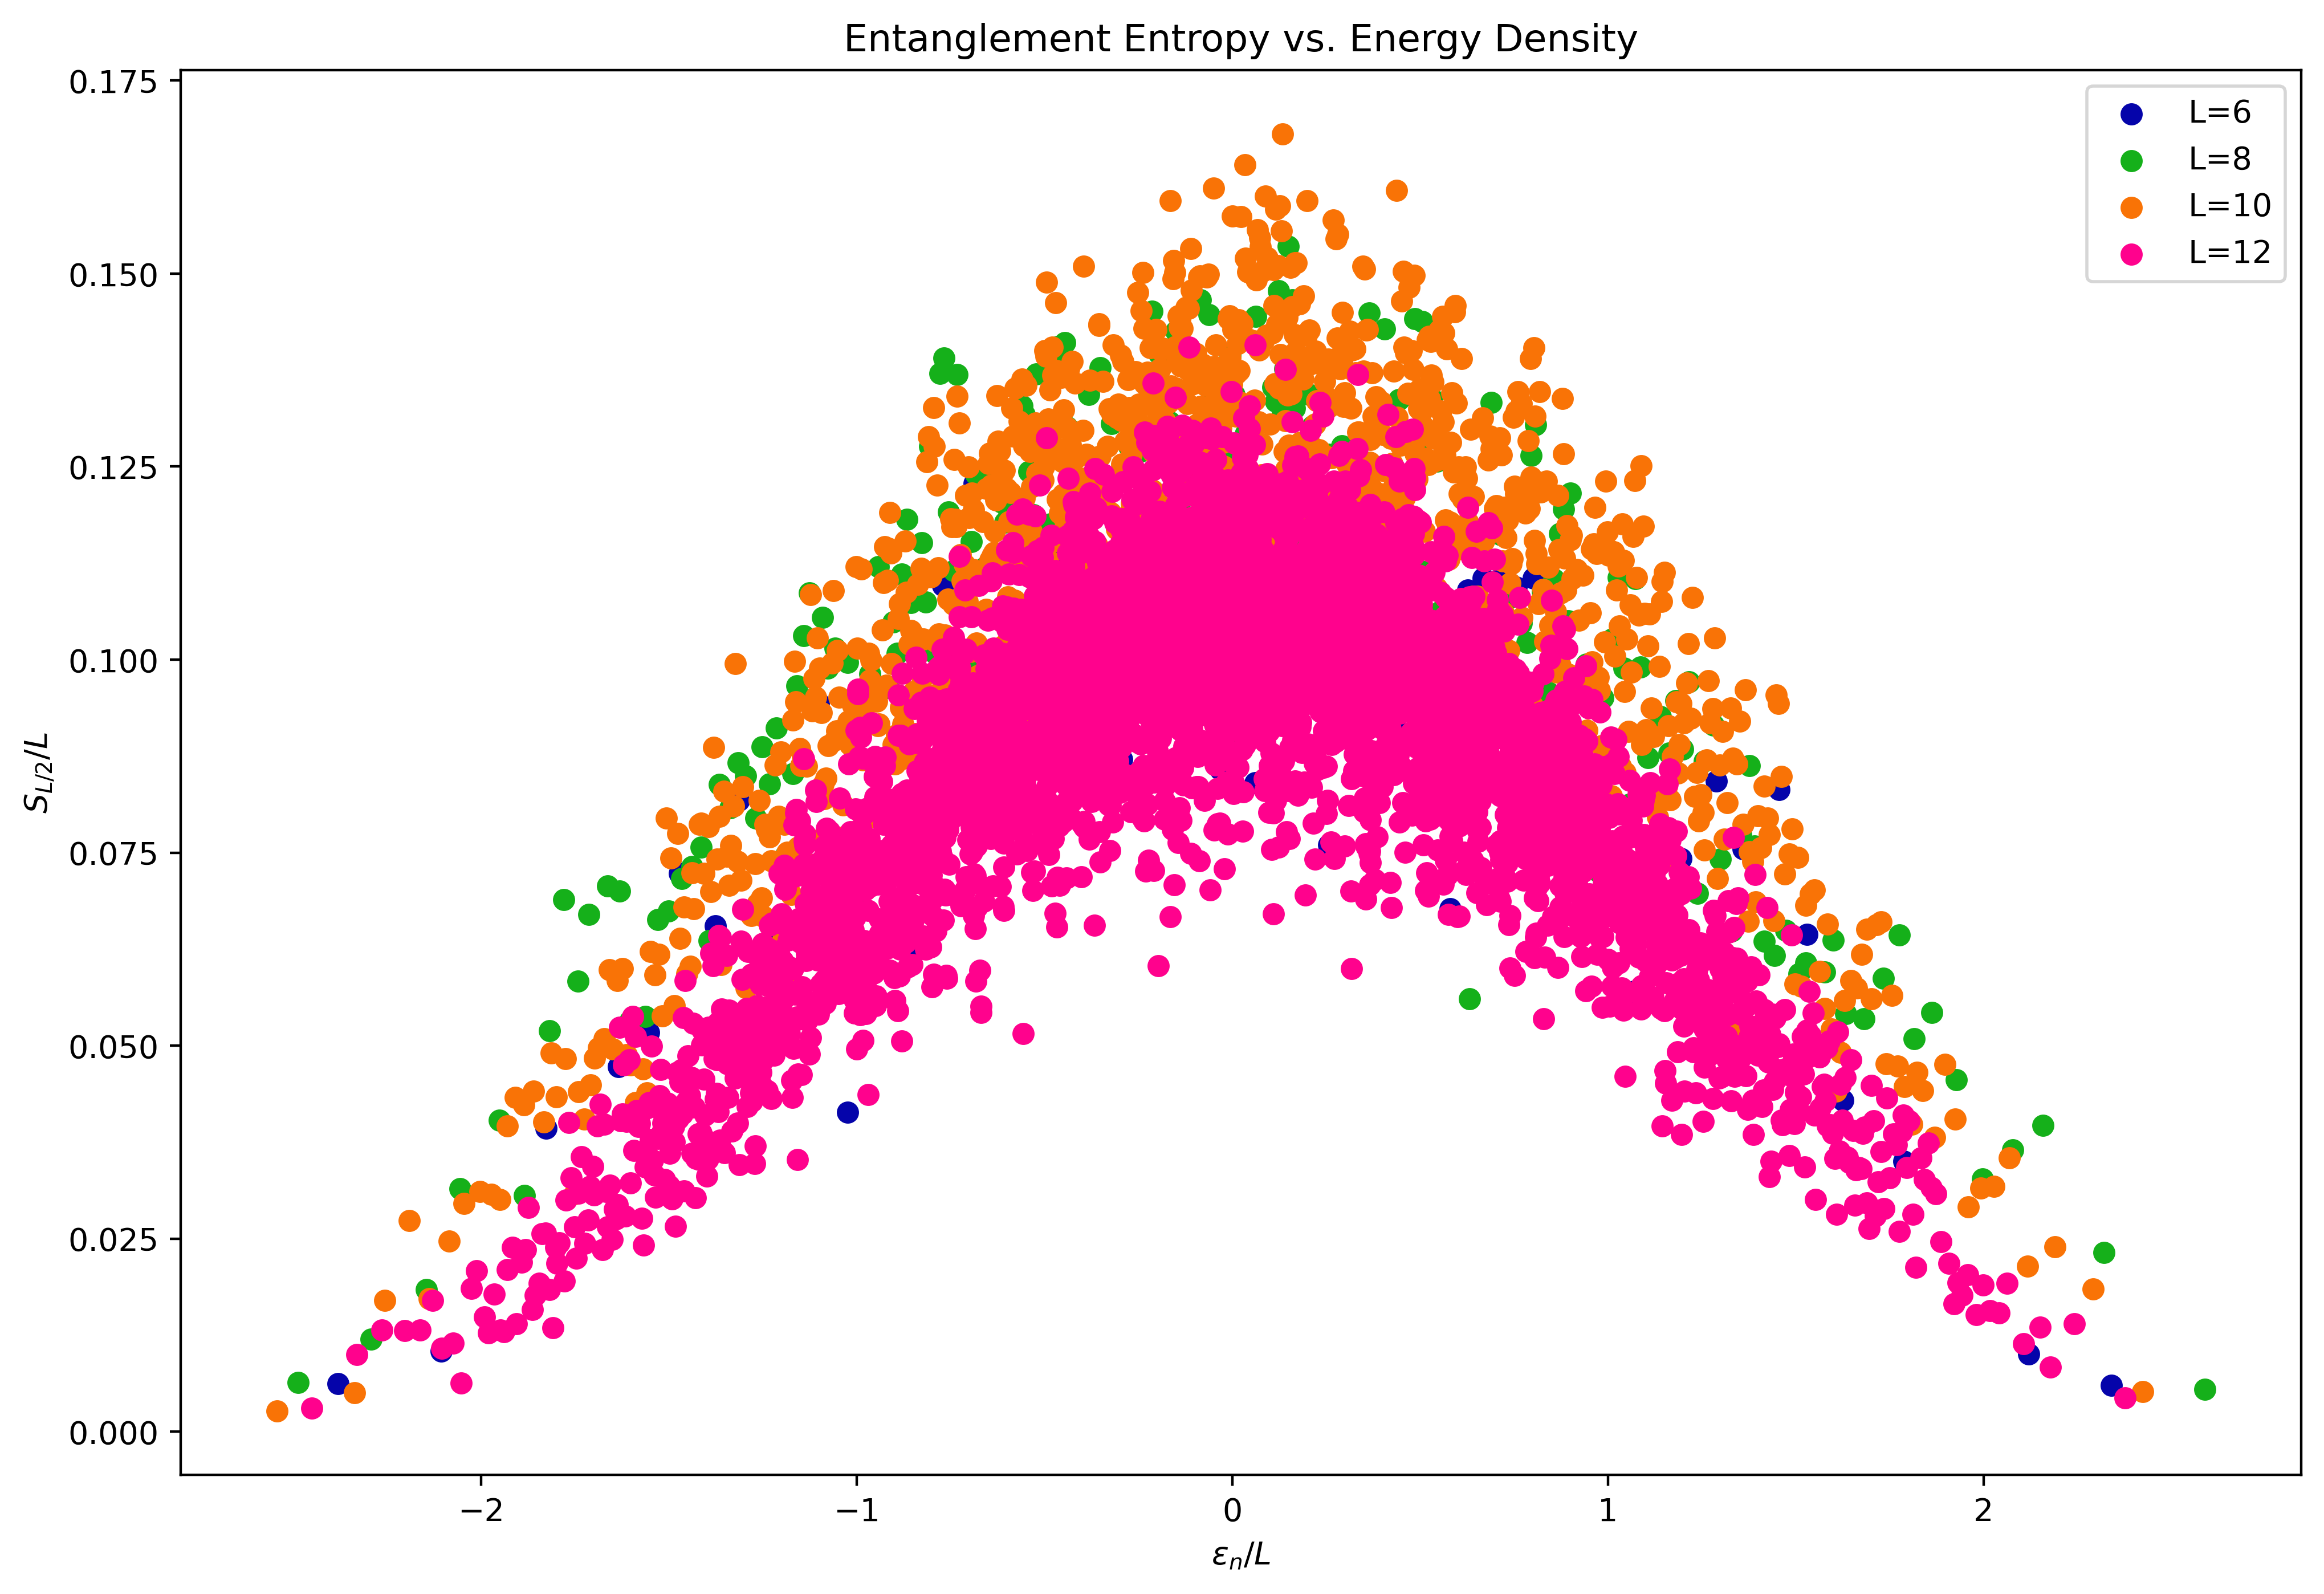

In [94]:
results = {L: {'energies': [], 'entropies': []} for L in Ls}

for i, L in enumerate(Ls):
    all_energies = []
    all_entropies = []

    for j in tqdm(range(num_realizations), desc=f'Processing L={L}'):
        eigenvalues = all_eigss[i][j]
        eigenvectors = all_vecss[i][j]

        energies = eigenvalues / L
        entropies_realization = []

        for vec in eigenvectors.T:
            entropy = entanglement_entropy(L, L//2, vec)
            entropies_realization.append(entropy)

        all_energies.append(energies)
        all_entropies.append(entropies_realization)

    # Averaging over realizations
    avg_energies = np.mean(all_energies, axis=0)
    avg_entropies = np.mean(all_entropies, axis=0) / L

    results[L]['energies'] = avg_energies
    results[L]['entropies'] = avg_entropies

plt.figure(figsize=(12, 8))

for i, L in enumerate(Ls):
    plt.scatter(results[L]['energies'], results[L]['entropies'], label=f'L={L}', color=xkcd_colors[i % len(xkcd_colors)])

plt.xlabel('$\epsilon_n / L$')
plt.ylabel('$S_{L/2} / L$')
plt.legend()
plt.title('Entanglement Entropy vs. Energy Density')
plt.savefig(os.path.join(directory, 'entropypart2_averaged.png'), dpi=400)
plt.show()